In [ ]:
!pip install bitstring

    100% |████████████████████████████████| 624kB 7.1MB/s 
  Running setup.py bdist_wheel for bitstring ... - done
  Stored in directory: /root/.cache/pip/wheels/2d/29/47/179175c4ddff694032837432ae45c04c6bf93e4b01c23fb5b3
Successfully built bitstring


In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from random import randint
from tkinter import *
import random
import bitstring
import math as m
import struct

In [ ]:
#Method to create a range of floats

def frange(x, y, jump):
  while x < y:
    yield round(x, -int(m.log10(jump)))
    x += jump

In [ ]:
#Method to define M1

def M1(x):
  return m.sin(5*m.pi*x)**6

In [ ]:
#Method to define M2

def M2(x):
  return (np.exp(-2*m.log(2)*((x-0.08)/0.854)**2))*((m.sin(5*m.pi*(x**0.75-0.05)))**6)

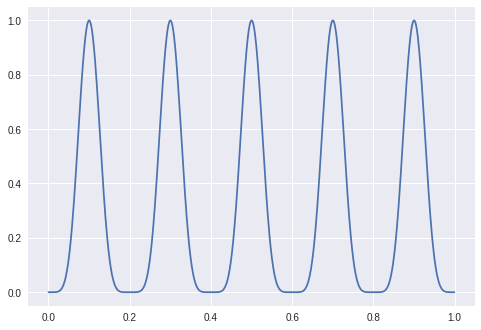

In [ ]:
#Printing M1 and M2 between 0 and 1 with 2 decimal points

plt.plot(list(frange(0, 1, 0.001)), [M1(x) for x in list(frange(0, 1, 0.001))])

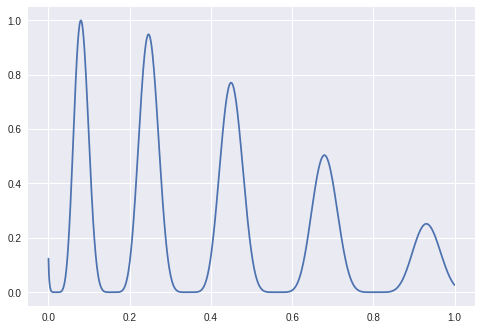

In [ ]:
plt.plot(list(frange(0, 1, 0.001)), [M2(x) for x in list(frange(0, 1, 0.001))])

In [ ]:
#Method to create a random float between 0 and 1 with -int(m.log10(jump)) decimal points

def create_random_solution(jump):
  return round(random.uniform(0, 1), -int(m.log10(jump)))

In [ ]:
#Method to convert a float to a 32-bit binary list

def float_to_binary(number):
  return bitstring.BitArray(float=number, length=32).bin

In [ ]:
#Method to convert a 32-bit binary list to float

def binary_to_float(binary_list):
  f = int(binary_list, 2)
  return round(struct.unpack('f', struct.pack('I', f))[0], 2)

In [ ]:
#Method to create the initial poulation

def create_initial_population(population_size, jump):
  initial_population = []
  for i in range(population_size):
    initial_population.append(float_to_binary(create_random_solution(jump)))
  return initial_population

In [ ]:
#Method to calculate the cost of a solution

def cost_of_solution(solution, function):
  function = eval(function)
  return function(binary_to_float(solution))

In [ ]:
#Method to create a dictionary of chromosomes with their finesses

def create_dictionary_with_percentages_of_cumulated_fitness(population, function):
  fitness_dictionary = dict((str(element),0) for element in population)
  for solution in population:
    fitness_dictionary[str(solution)] = cost_of_solution(solution, function)
  sum_of_fitnesses = sum(fitness_dictionary.values())
  for solution in population:
    fitness_dictionary[str(solution)] = fitness_dictionary[str(solution)] / sum_of_fitnesses
  return fitness_dictionary

In [ ]:
#Method for random wheel selection

def random_wheel_selection(fitness_dictionary):
    max = sum(fitness_dictionary.values())
    pick = random.uniform(0, max)
    current = 0
    for key, value in fitness_dictionary.items():
        current += value
        if current > pick:
            return key

In [ ]:
#Method for crossover using a random cut point

def crossover_with_random_cutpoint(parent_1, parent_2):
  cut_point = randint(0, len(parent_1)-2)
  crossover_child = parent_1[0:cut_point] + parent_2[cut_point:len(parent_2)]
  return crossover_child

In [ ]:
#Method for crossover using a section in the middle with random length

def crossover_with_section_in_middle(parent_1, parent_2):
  cut_point_1 = randint(0, len(parent_1)-2)
  cut_point_2 = cut_point_1 + randint(1, len(parent_1)-cut_point_1-1)
  crossover_child = parent_2[0:cut_point_1] + parent_1[cut_point_1:cut_point_2+1] + parent_2[cut_point_2+1:len(parent_2)]
  return crossover_child

In [ ]:
#Method to generate the crossover solutions

def generate_crossover_solutions(population, percentage_crossover, crossover_method):
  fitness_dictionary = create_dictionary_with_percentages_of_cumulated_fitness(population, function)
  Number_of_crossover_solutions = int(percentage_crossover * len(population))
  crossover_solutions = []
  for i in range(Number_of_crossover_solutions):
    parent_1 = random_wheel_selection(fitness_dictionary)
    parent_2 = random_wheel_selection(fitness_dictionary)
    if crossover_method == 'Random cutpoint':
      crossover_solutions.append(crossover_with_random_cutpoint(parent_1, parent_2))
    elif crossover_method == 'Random section in middle':
      crossover_solutions.append(crossover_with_section_in_middle(parent_1, parent_2))
  return crossover_solutions

In [ ]:
#Method to generate the crossover solutions with crowding

def generate_crossover_solutions_with_crowding(population, crossover_method):
  random.shuffle(population)
  parents_1 = population[0:len(population)//2]
  parents_2 = population[len(population)//2:len(population)//2+len(parents_1)]
  crossover_solutions = []
  for i in range(len(parents_1)):
    intermediate_crossover_solutions = [parents_1[i], parents_2[i]]
    if crossover_method == 'Random cutpoint':
      intermediate_crossover_solutions.append(crossover_with_random_cutpoint(parents_1[i], parents_2[i]))
      intermediate_crossover_solutions.append(crossover_with_random_cutpoint(parents_1[i], parents_2[i]))
    elif crossover_method == 'Random section in middle':
      intermediate_crossover_solutions.append(crossover_with_section_in_middle(parents_1[i], parents_2[i]))
      intermediate_crossover_solutions.append(crossover_with_section_in_middle(parents_1[i], parents_2[i]))
    intermediate_crossover_solutions = select_elit_population(intermediate_crossover_solutions, [], [], 2)
    crossover_solutions.append(intermediate_crossover_solutions)
  crossover_solutions = [item for sublist in crossover_solutions for item in sublist]
  if len(population) % 2 != 0:
    crossover_solutions.append(population[-1])
  return crossover_solutions

In [ ]:
#Method to generate mutated solutions

def generate_mutated_solutions(population, percentage_mutation):
  number_of_mutated_solutions = int(percentage_mutation * len(population))
  mutated_solutions = []
  for i in range(number_of_mutated_solutions):
    parent = random.choice(population)
    index = randint(0, len(parent)-1)
    if parent[index] == 0:
      intermediate = list(parent)
      intermediate[index] = '1'
      parent = ''.join(intermediate)
    else:
      intermediate = list(parent)
      intermediate[index] = '0'
      parent = ''.join(intermediate)
    mutated_solutions.append(parent)
  return mutated_solutions

In [ ]:
#Method to select the elit population

def select_elit_population(population, crossover_paths, mutated_paths, population_size):
  grouped_population = population + crossover_paths + mutated_paths
  fitness_dictionary = create_dictionary_with_percentages_of_cumulated_fitness(grouped_population, function)
  elit_population = sorted(fitness_dictionary, key=fitness_dictionary.get, reverse=True)[:population_size]
  return elit_population

In [ ]:
#Method to calculate the min, max and average costs of a population

def cost_of_population(population, function):
  min_cost = 9999999999999999999999999
  max_cost = 0
  average_cost = 0
  for solution in population:
    cost = cost_of_solution(solution, function)
    if cost < min_cost:
      min_cost = cost
    if cost > max_cost:
      max_cost = cost
  average_cost = (max_cost + min_cost) / 2
  return min_cost, max_cost, average_cost

In [ ]:
#Method to get the best solution in a population

def best_solution_in_population(population, function):
  best_solution = []
  min_cost = 9999999999999999999999999
  for solution in population:
    cost = cost_of_solution(solution, function)
    if cost < min_cost:
      min_cost = cost
      best_solution = solution
  return best_solution

In [ ]:
#Method to plot the solutions

def plot_solutions(solutions, function):
  plt.figure()
  plt.xlim(0, 1)
  plt.plot(list(frange(0, 1, 0.001)), [eval(function)(x) for x in list(frange(0, 1, 0.001))])
  for solution in solutions:
    plt.scatter(binary_to_float(solution), eval(function)(binary_to_float(solution)))
  plt.show()

In [ ]:
#Method to plot the evolution over time

def plot_evolution_over_time(min_costs_over_time, max_costs_over_time, average_costs_over_time):
  plt.plot(list(range(len(average_costs_over_time))), average_costs_over_time, color='b', label='Average cost')
  plt.plot(list(range(len(min_costs_over_time))), min_costs_over_time, color='g', label='Min cost')
  plt.plot(list(range(len(max_costs_over_time))), max_costs_over_time, color='r', label='Max cost')
  plt.xlabel('Iteration')
  plt.ylabel('Path cost')
  plt.legend()
  plt.show()

In [ ]:
#Method to apply GA with parallel hillclimbing niching

def GA_with_parallel_hillclimbing(population_size, number_iterations, number_solutions, percentage_crossover, crossover_method, percentage_mutation, function):

  best_solutions = []
  for j in range(number_solutions):

    #Initializing and creating initial population
    min_costs_over_time = []
    max_costs_over_time = []
    average_costs_over_time = []
    population = create_initial_population(population_size, jump)
    min_cost, max_cost, average_cost = cost_of_population(population, function)
    min_costs_over_time.append(min_cost)
    max_costs_over_time.append(max_cost)
    average_costs_over_time.append(average_cost)

    for i in range(number_iterations):

      #Crossover
      crossover_solutions = generate_crossover_solutions(population, percentage_crossover, crossover_method)

      #Mutation
      mutated_solutions = generate_mutated_solutions(population, percentage_mutation)

      #Elitism
      population = select_elit_population(population, crossover_solutions, mutated_solutions, population_size)

      min_cost, max_cost, average_cost = cost_of_population(population, function)
      min_costs_over_time.append(min_cost)
      max_costs_over_time.append(max_cost)
      average_costs_over_time.append(average_cost)

    plot_evolution_over_time(min_costs_over_time, max_costs_over_time, average_costs_over_time)
    best_solution = best_solution_in_population(population, function)
    best_solutions.append(best_solution)

  return best_solutions

In [ ]:
#Method to apply GA with crowding niching

def GA_with_crowding(population_size, number_iterations, crossover_method, function):

  #Initializing and creating initial population
  min_costs_over_time = []
  max_costs_over_time = []
  average_costs_over_time = []
  population = create_initial_population(population_size, jump)
  min_cost, max_cost, average_cost = cost_of_population(population, function)
  min_costs_over_time.append(min_cost)
  max_costs_over_time.append(max_cost)
  average_costs_over_time.append(average_cost)

  for i in range(number_iterations):

    #Crossover
    population = generate_crossover_solutions_with_crowding(population, crossover_method)

    min_cost, max_cost, average_cost = cost_of_population(population, function)
    min_costs_over_time.append(min_cost)
    max_costs_over_time.append(max_cost)
    average_costs_over_time.append(average_cost)

  plot_evolution_over_time(min_costs_over_time, max_costs_over_time, average_costs_over_time)
  best_solutions = population

  return best_solutions

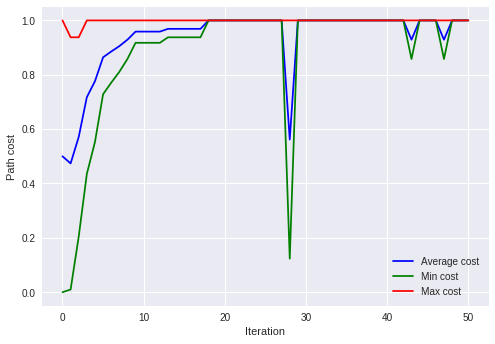

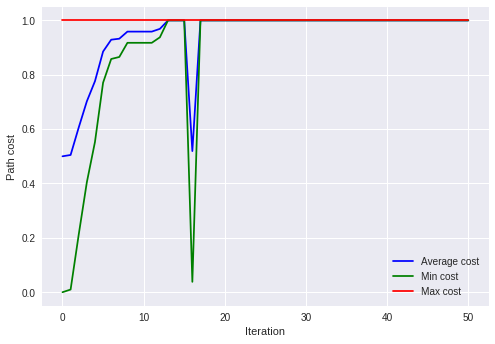

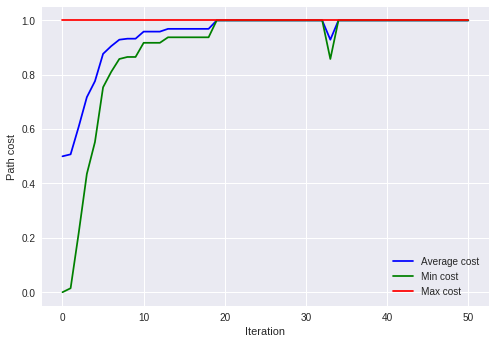

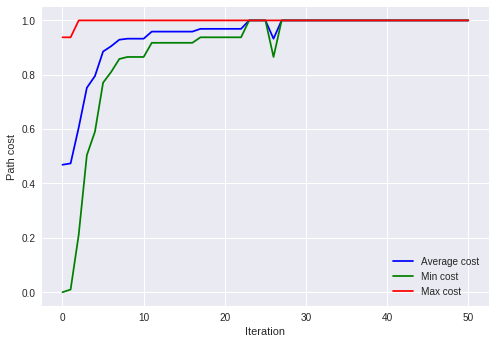

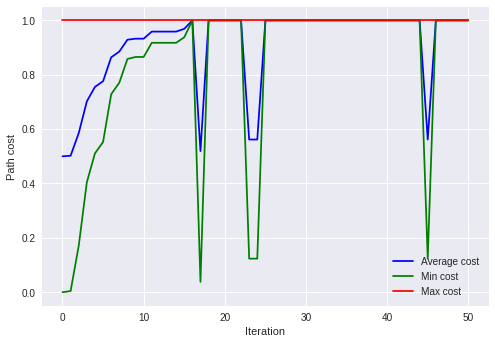

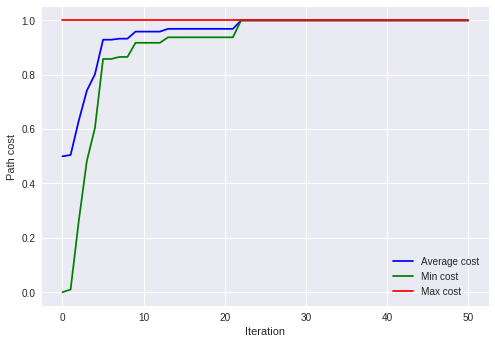

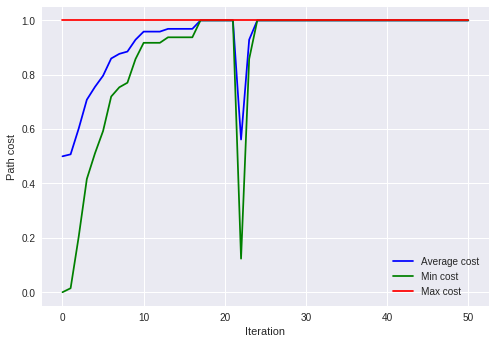

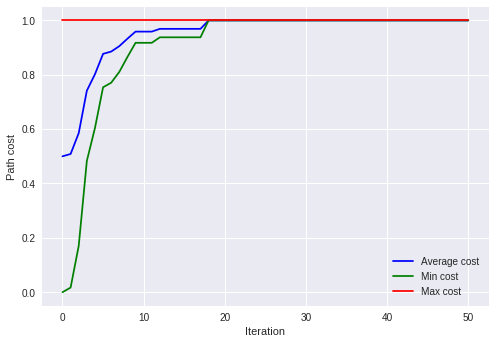

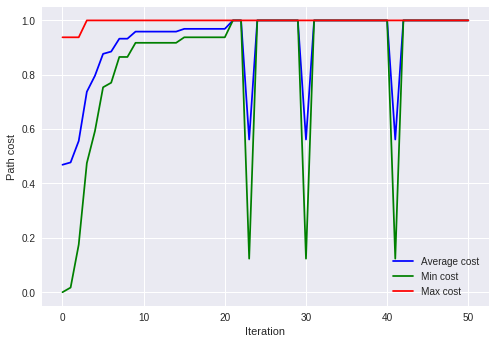

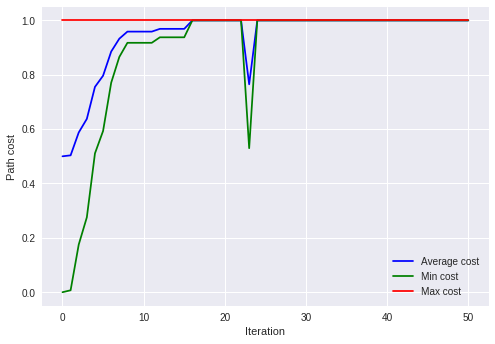

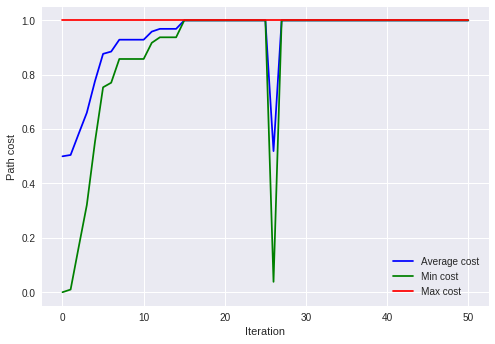

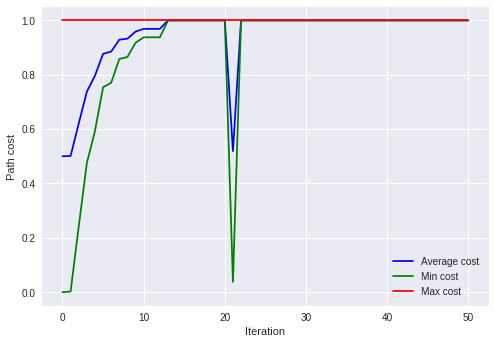

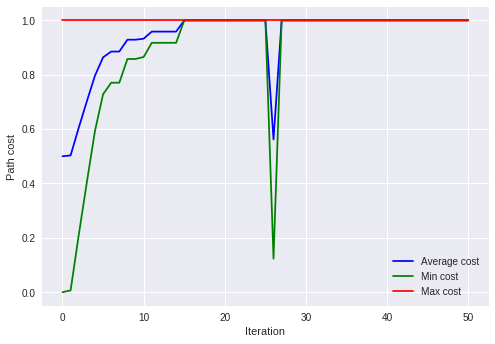

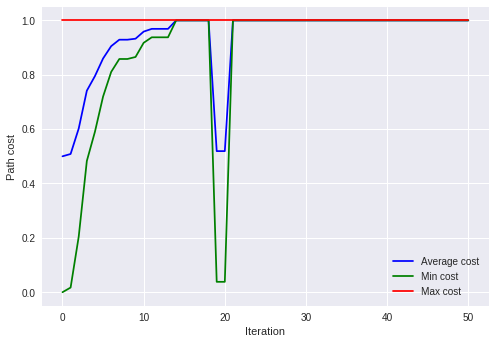

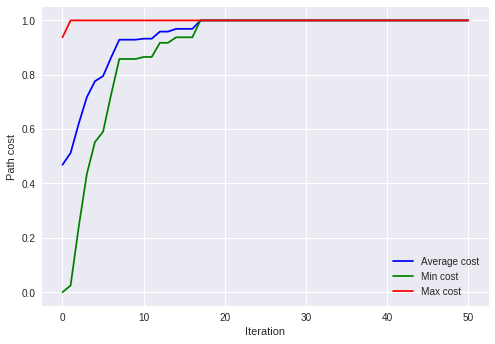

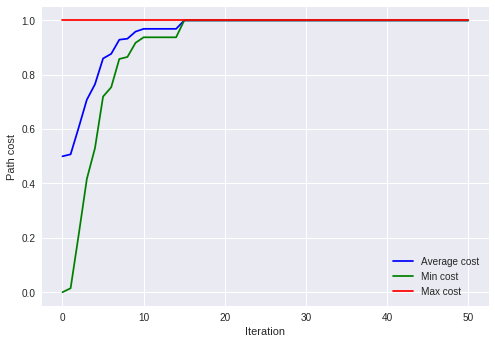

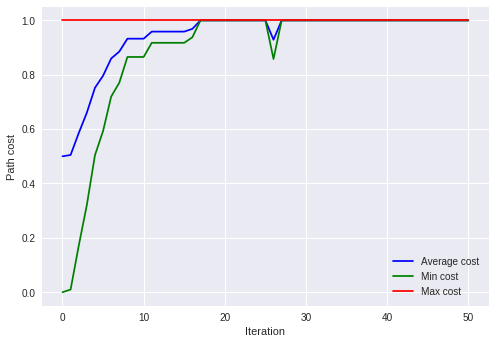

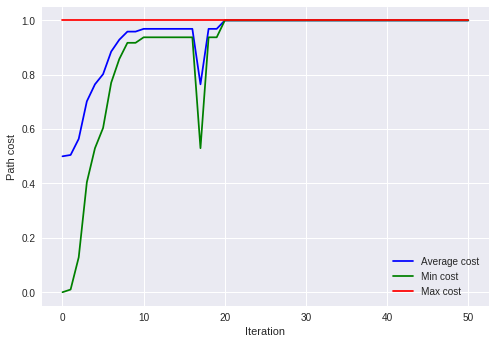

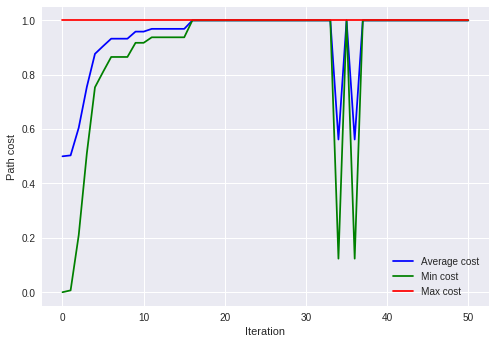

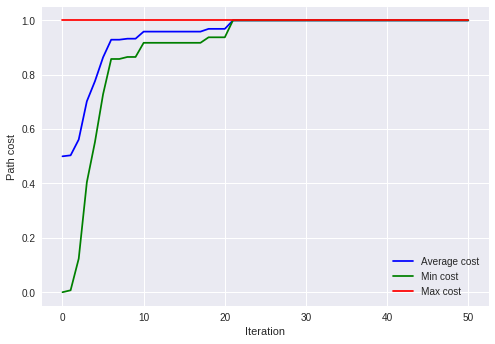

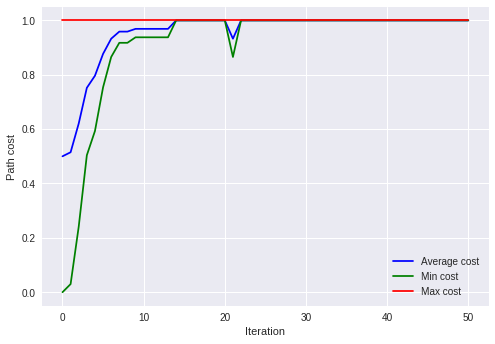

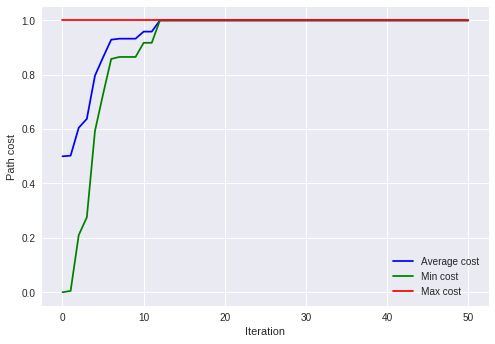

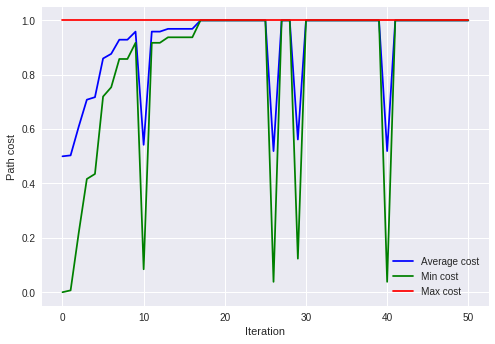

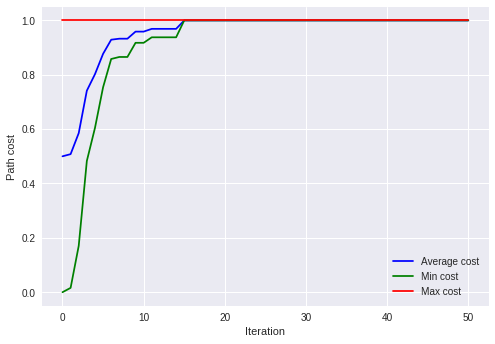

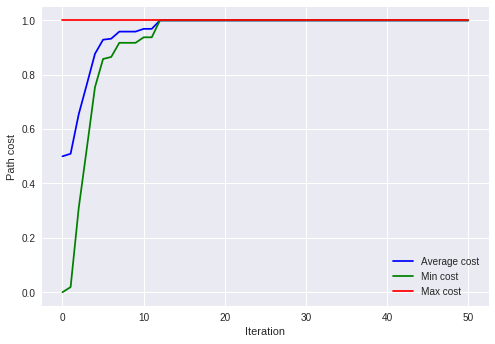

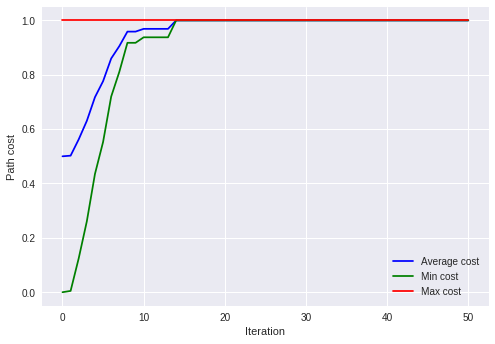

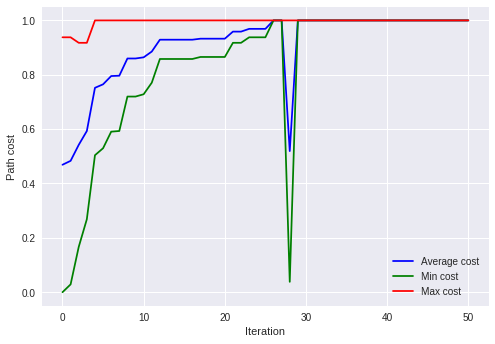

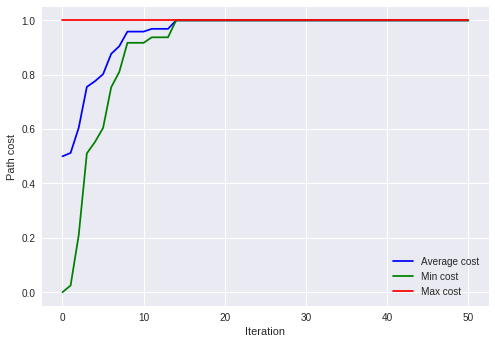

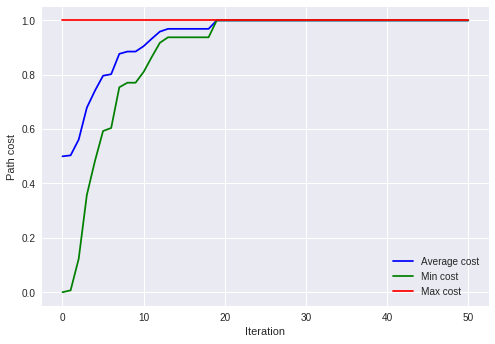

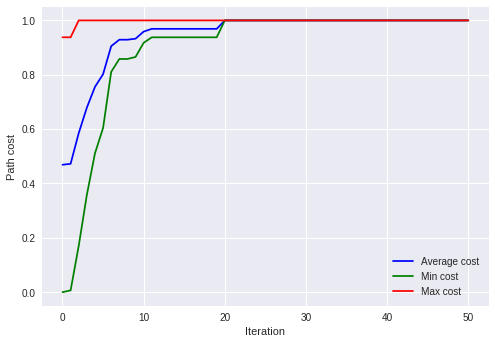

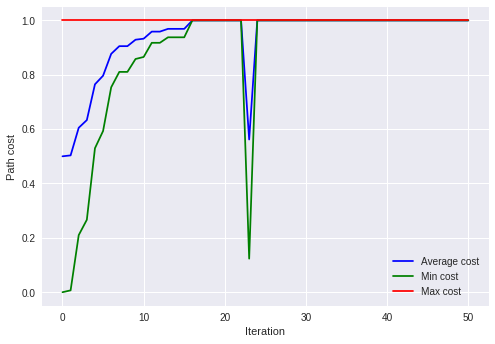

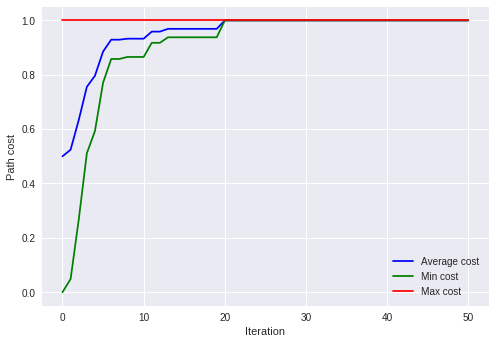

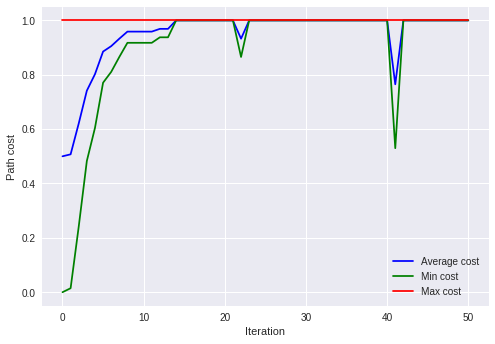

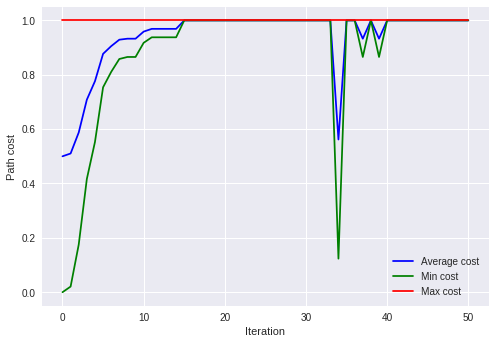

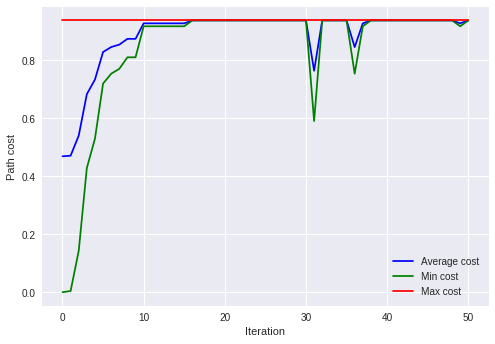

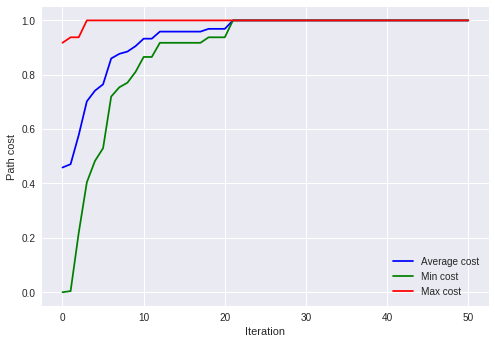

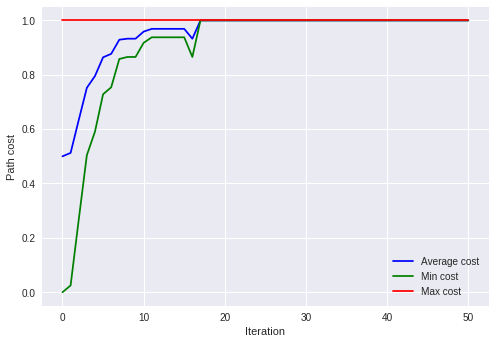

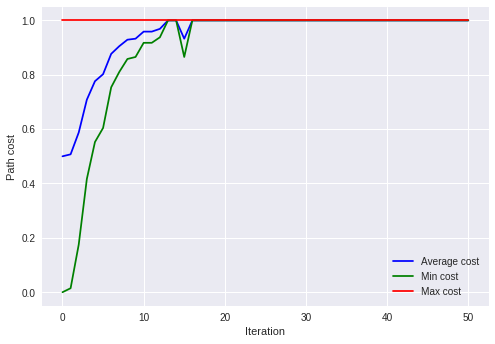

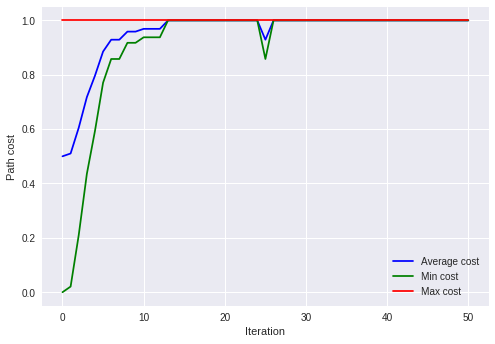

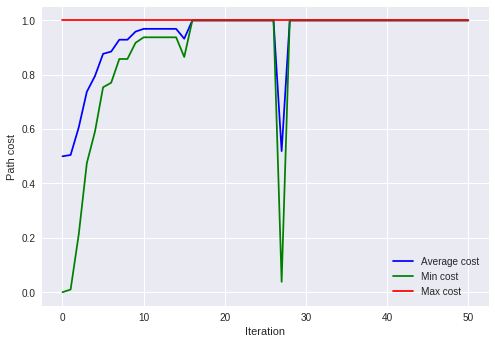

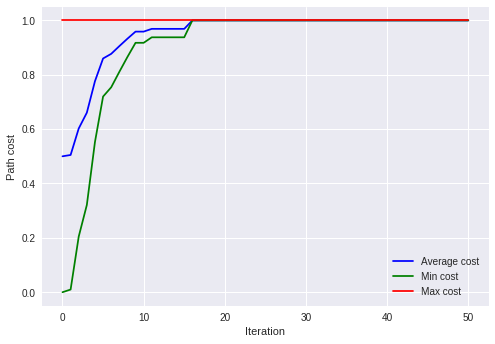

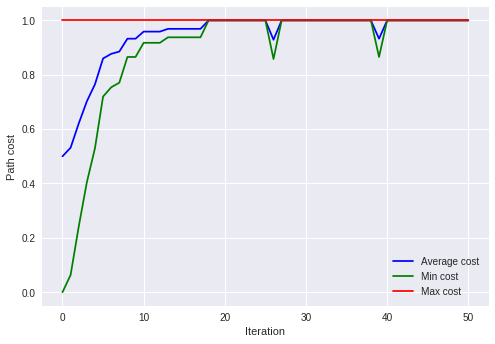

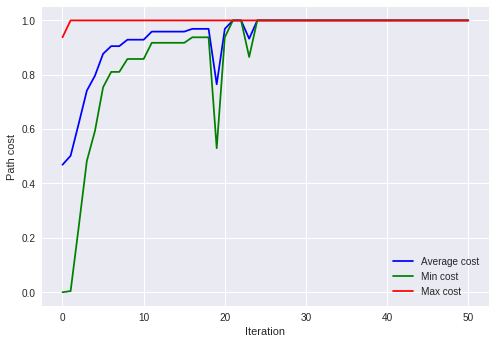

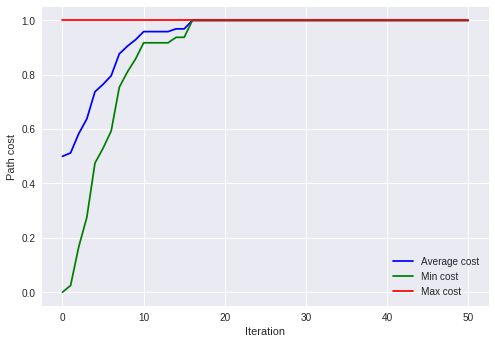

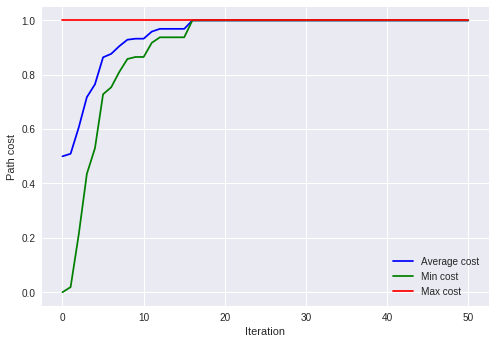

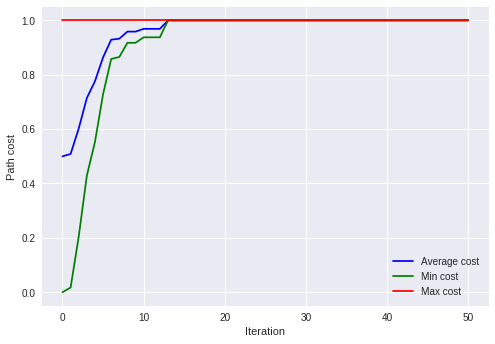

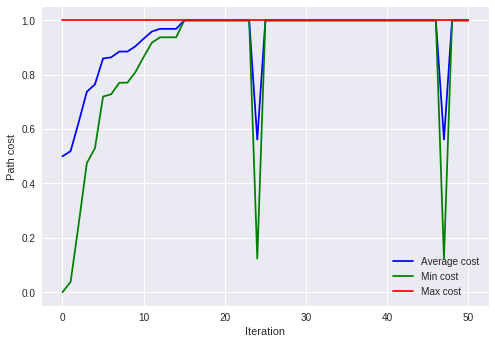

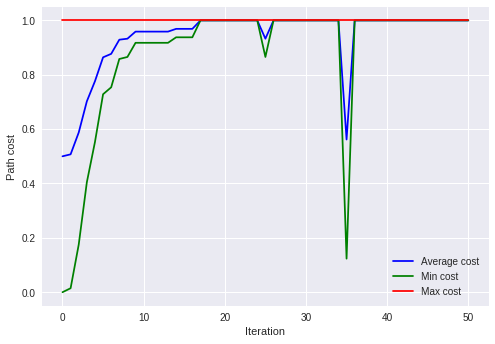

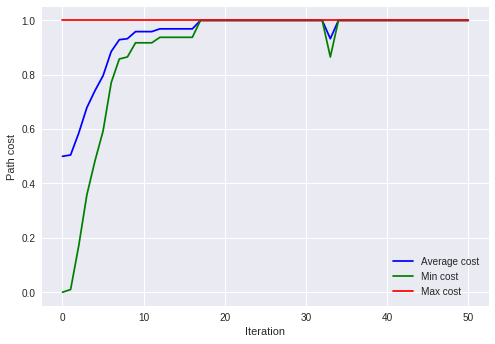

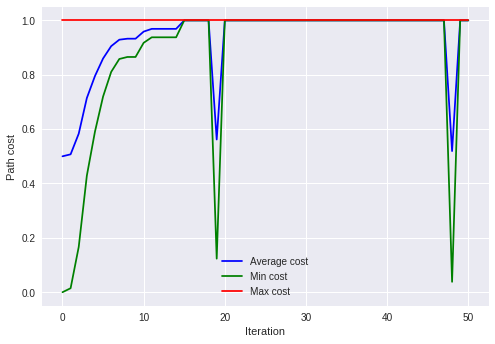

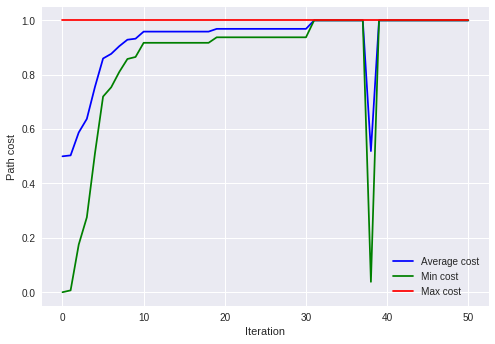

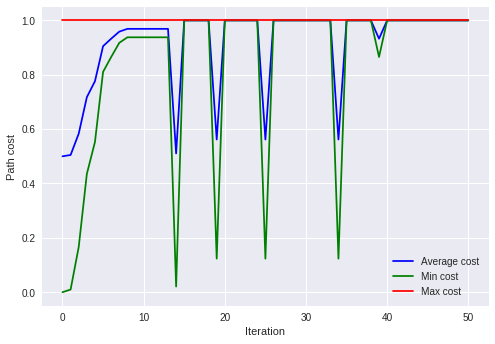

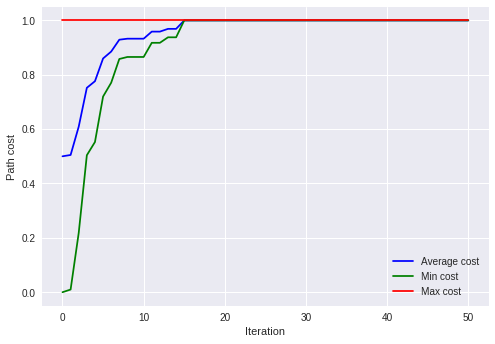

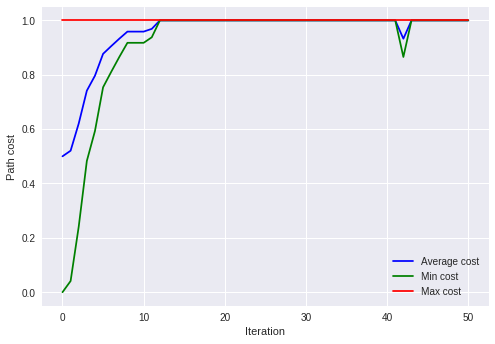

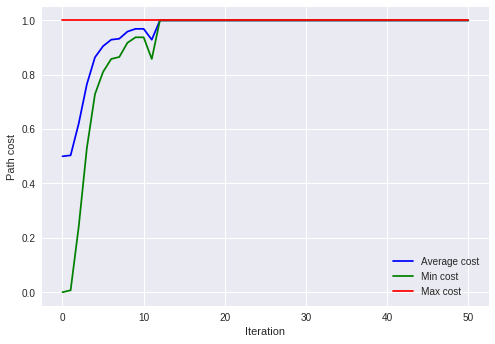

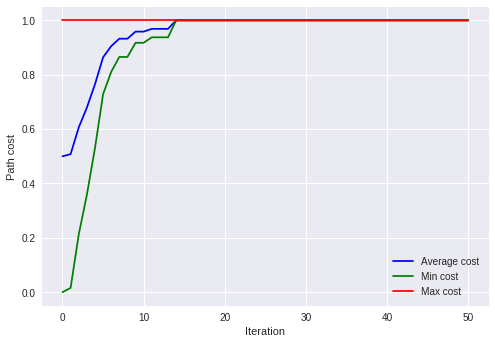

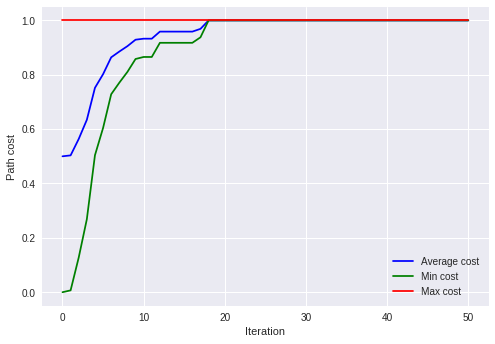

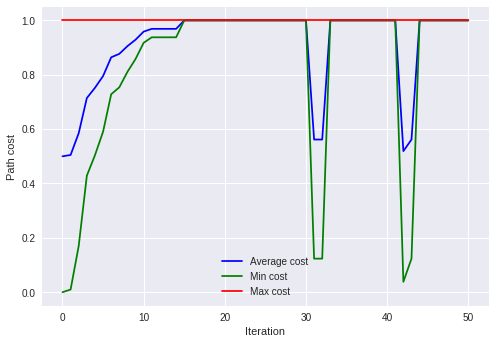

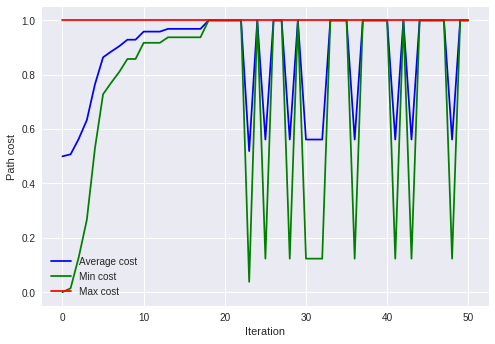

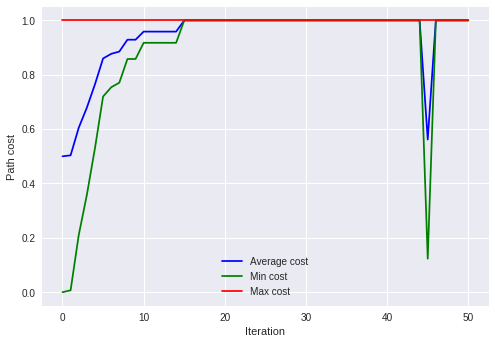

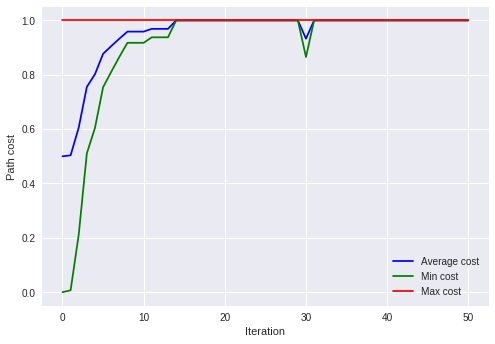

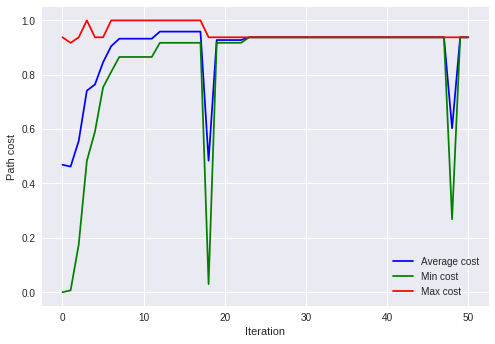

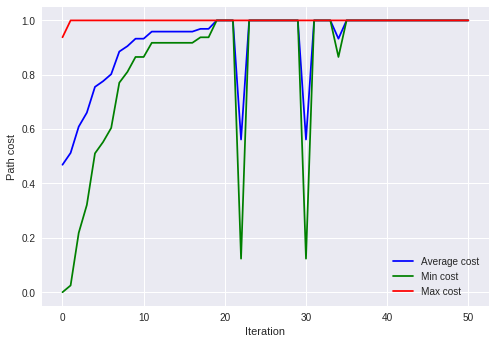

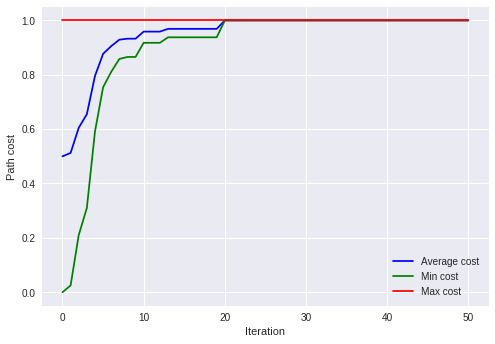

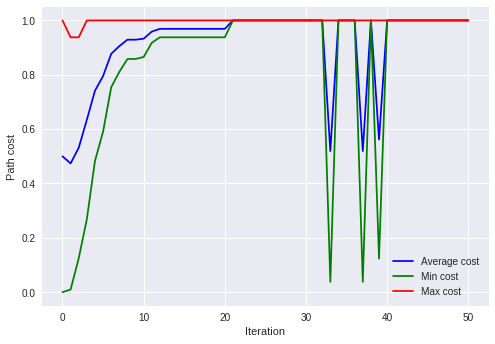

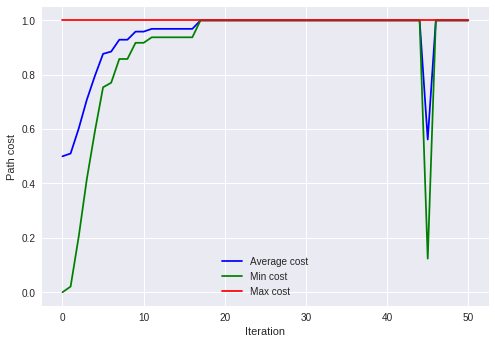

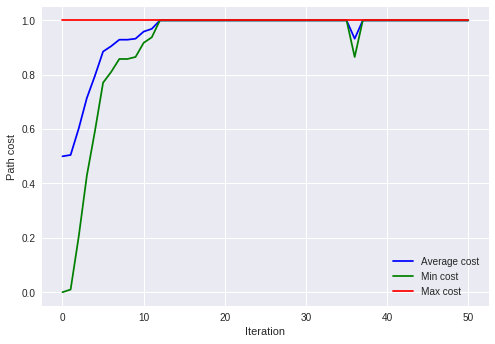

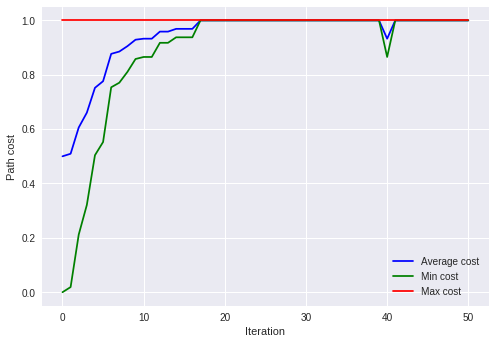

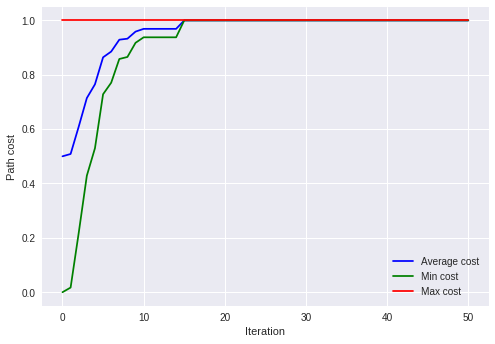

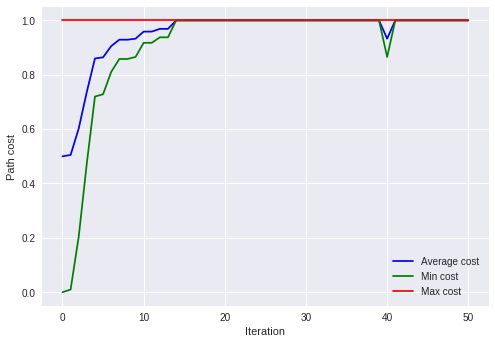

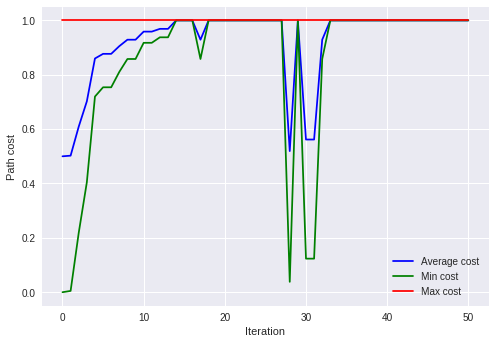

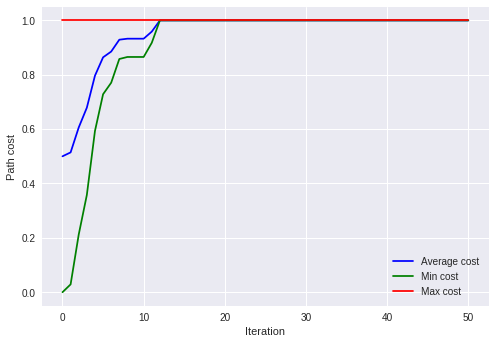

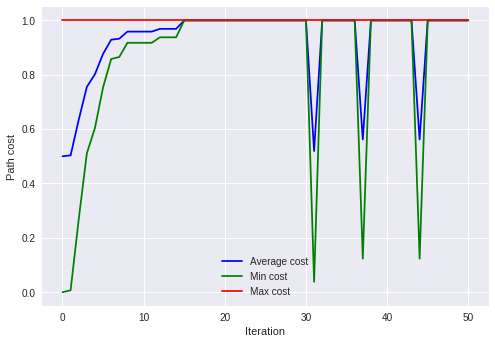

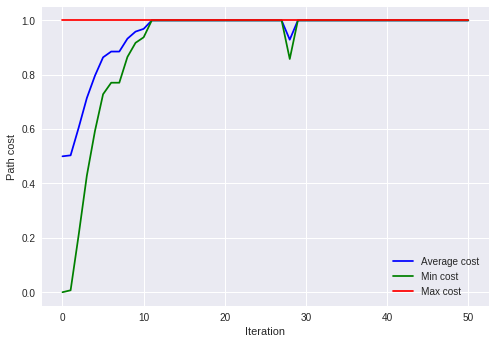

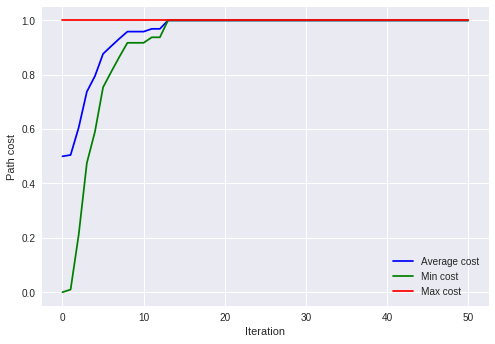

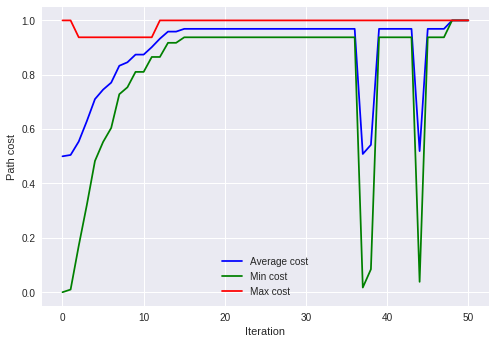

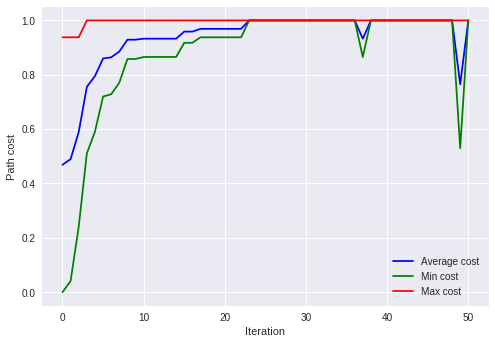

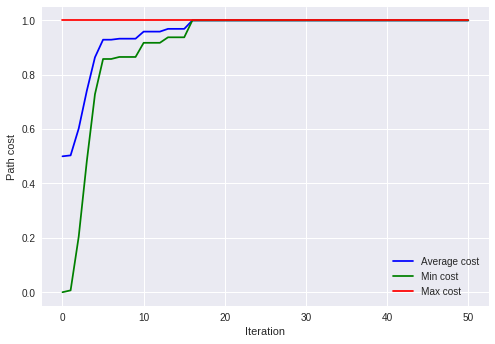

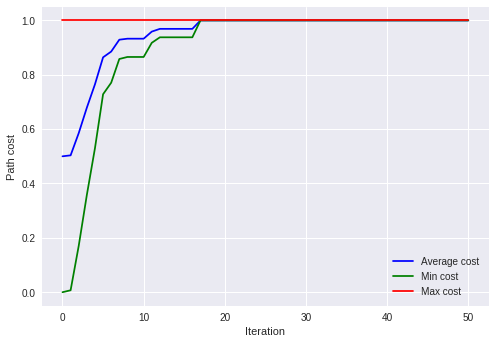

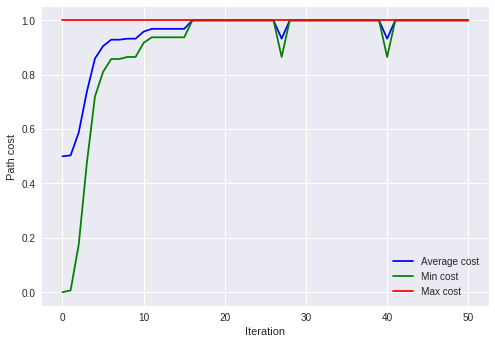

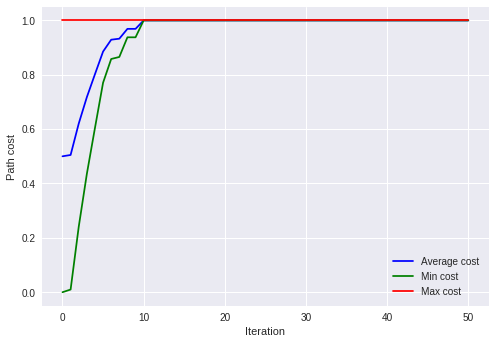

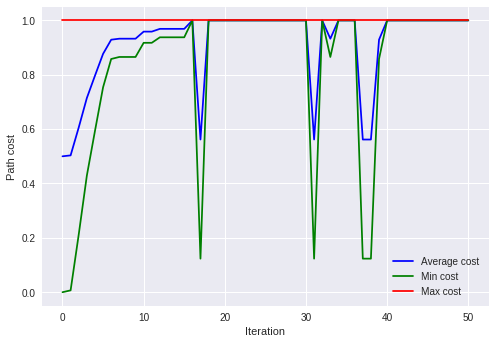

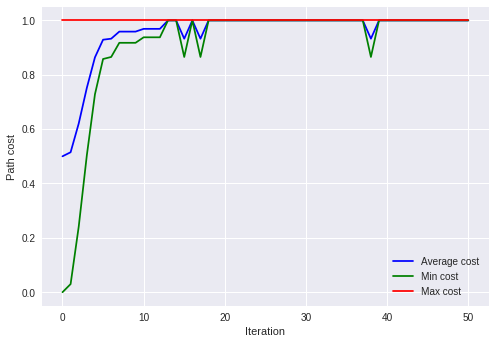

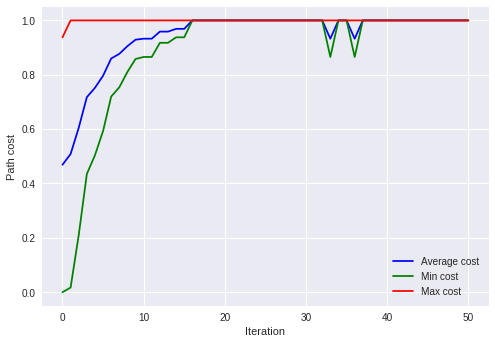

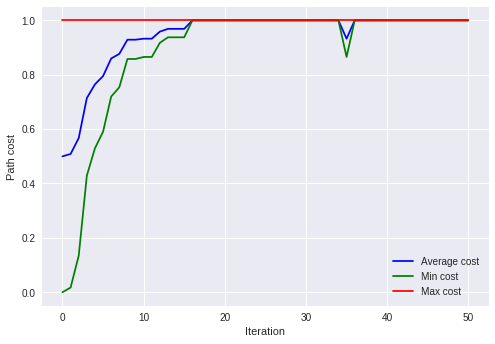

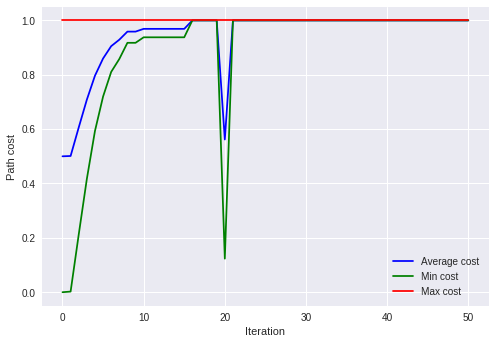

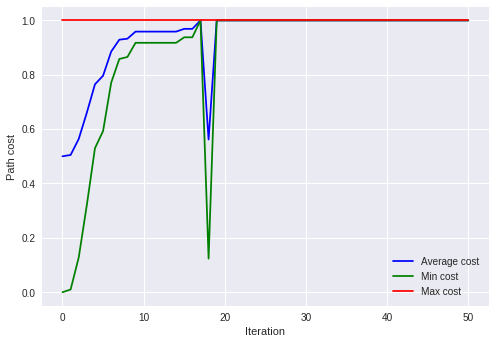

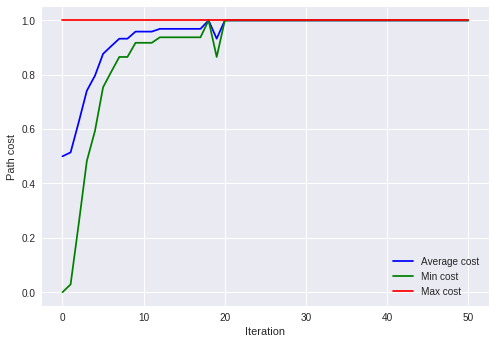

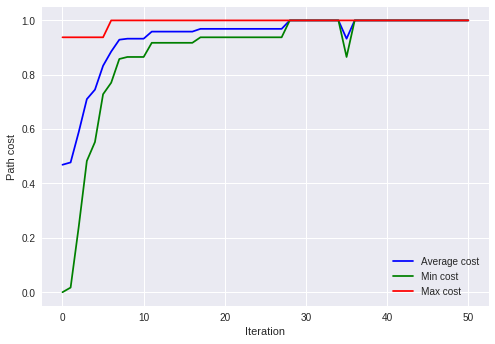

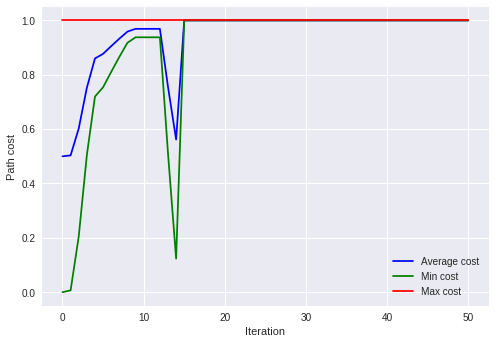

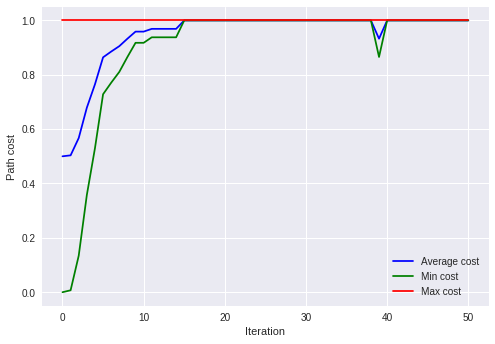

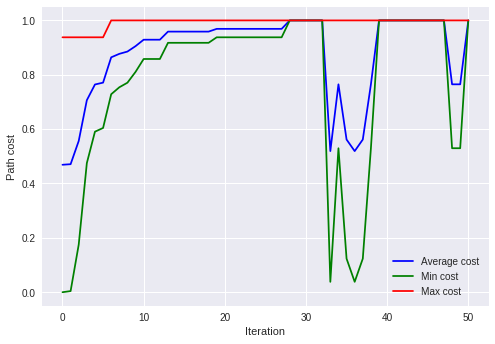

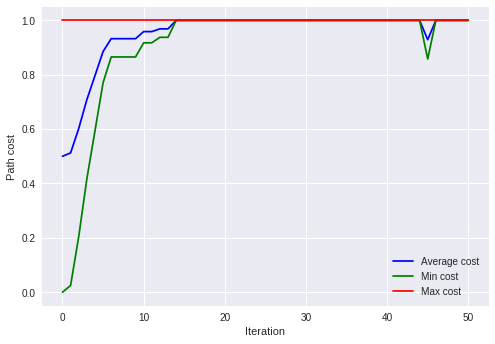

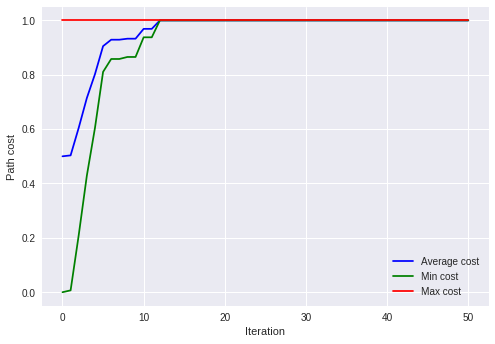

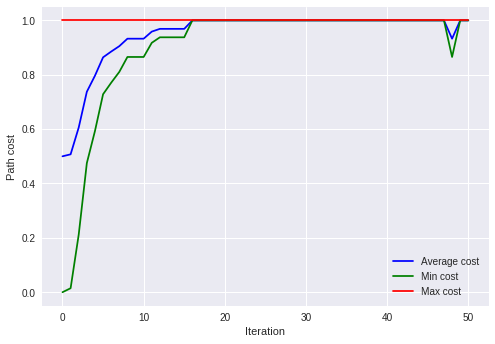

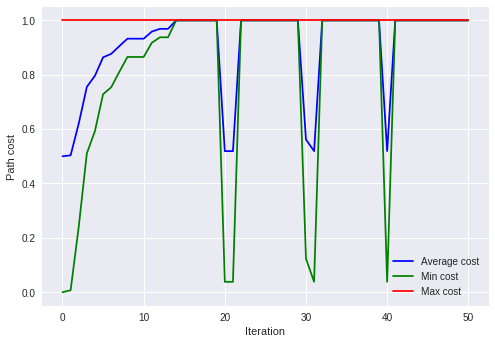

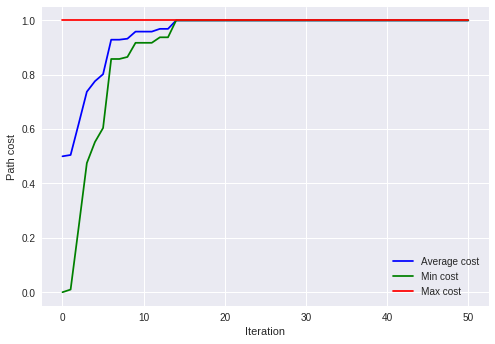

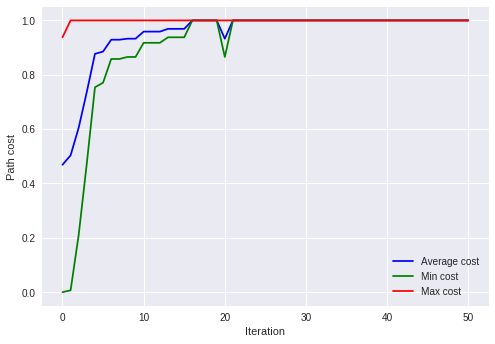

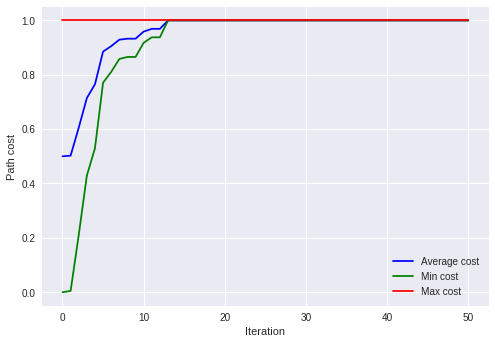

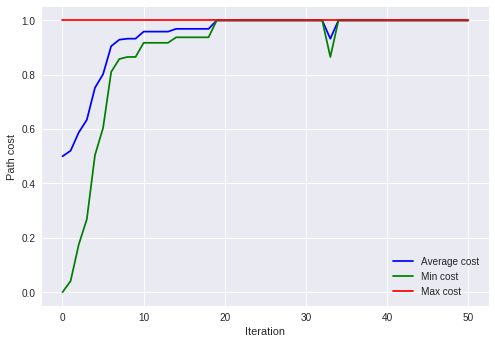

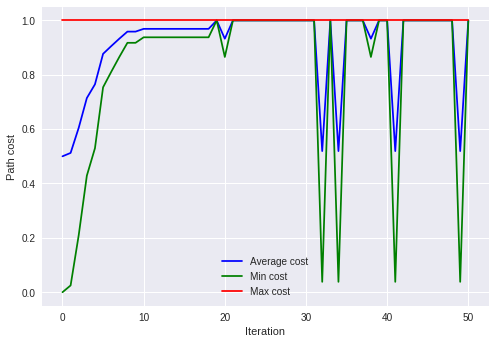

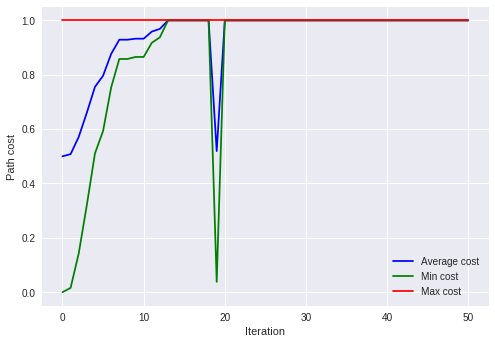

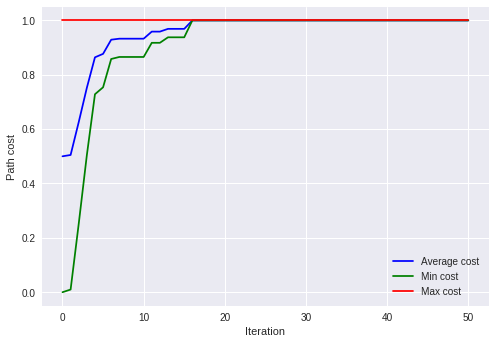

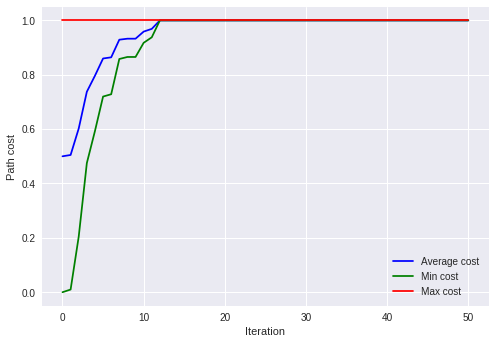

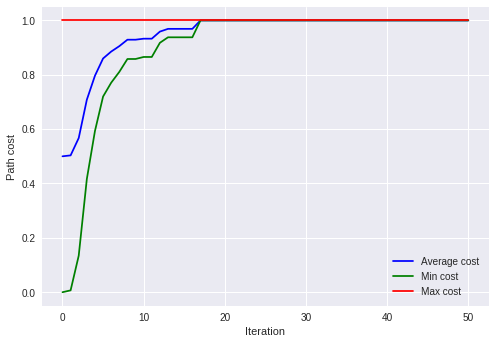

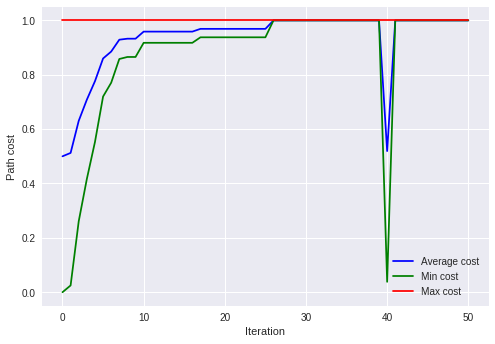

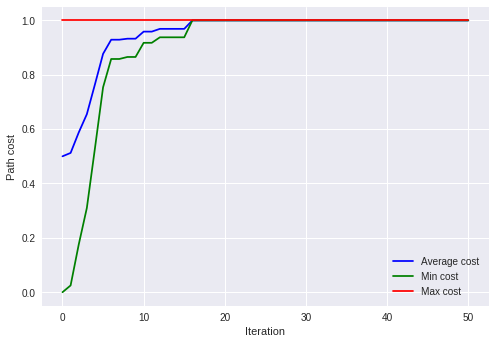

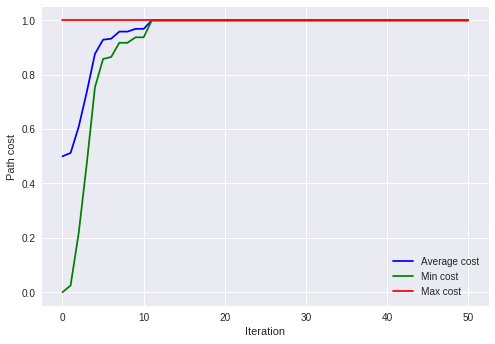

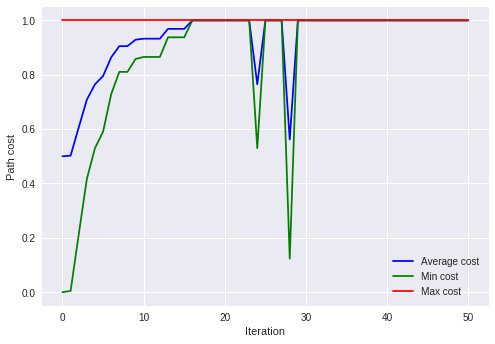

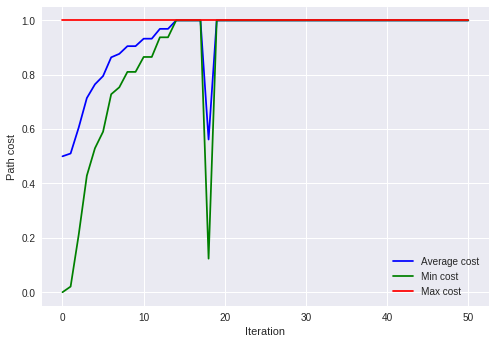

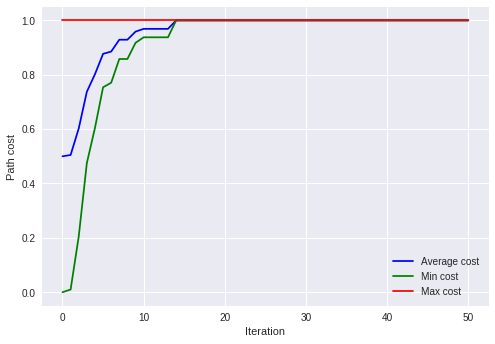

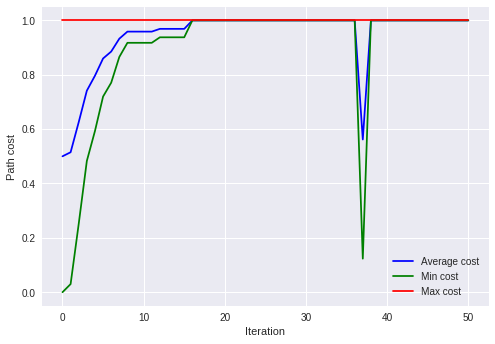

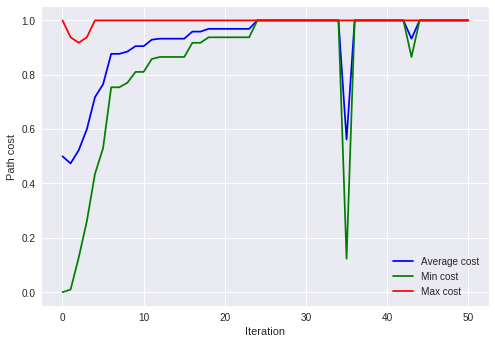

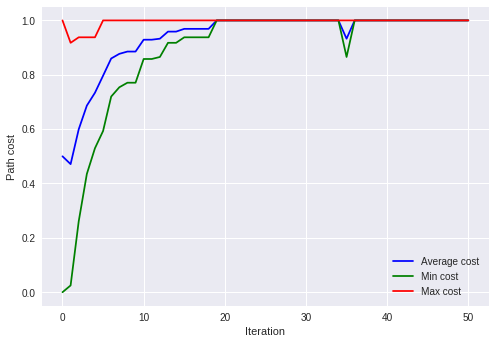

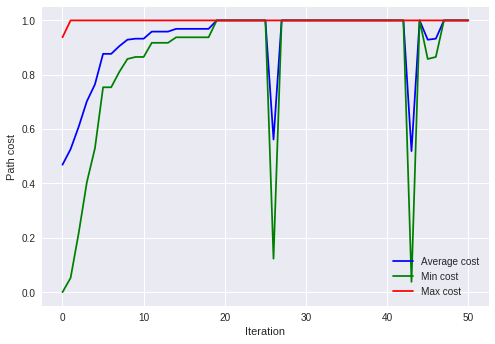

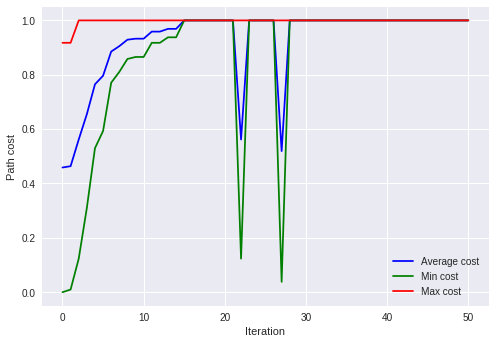

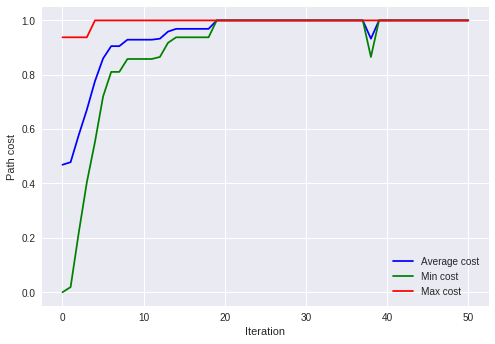

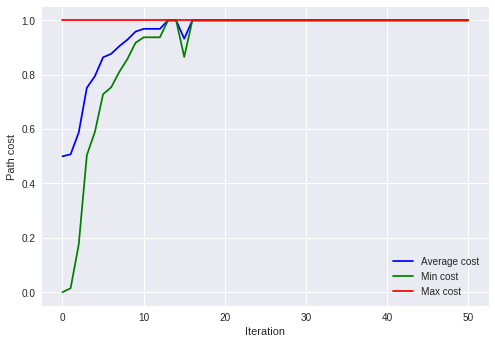

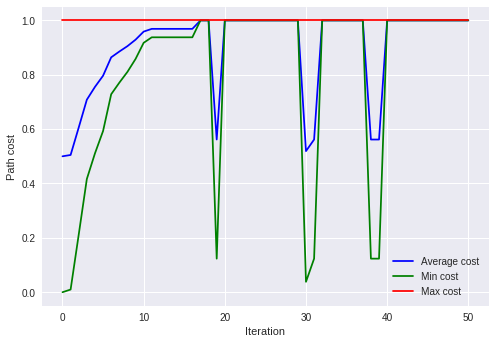

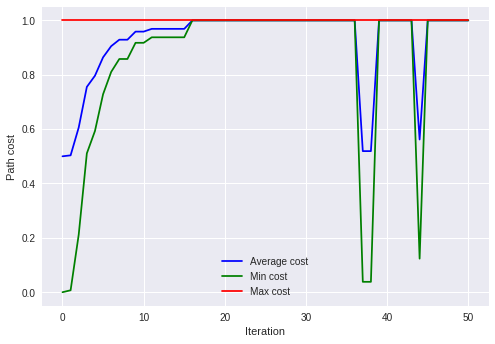

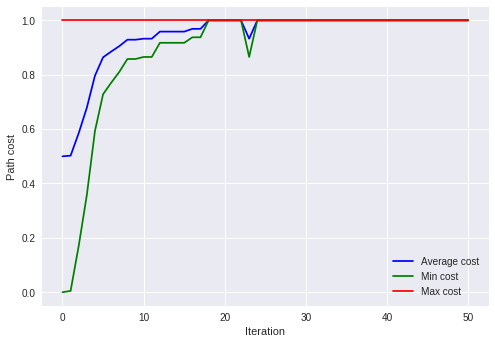

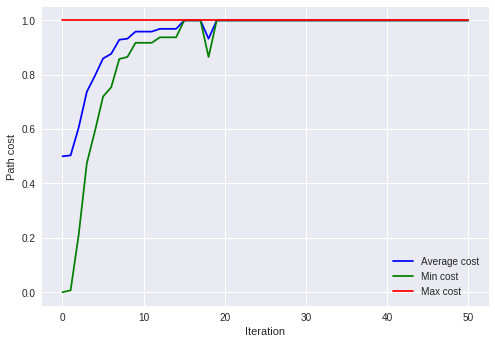

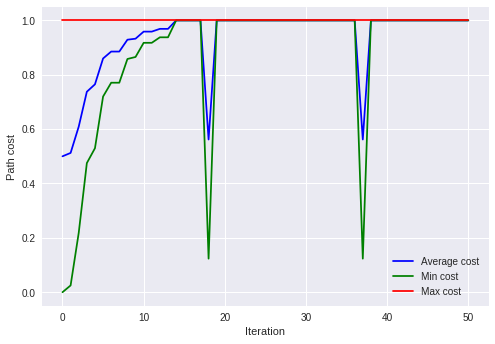

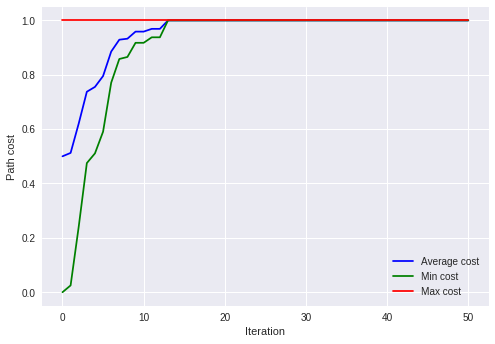

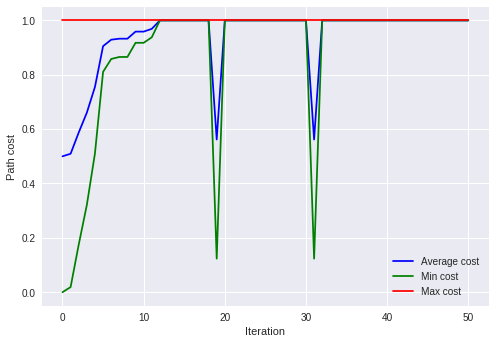

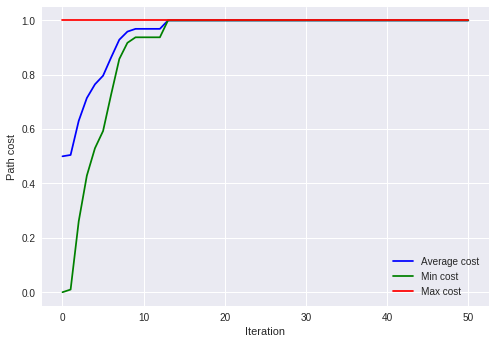

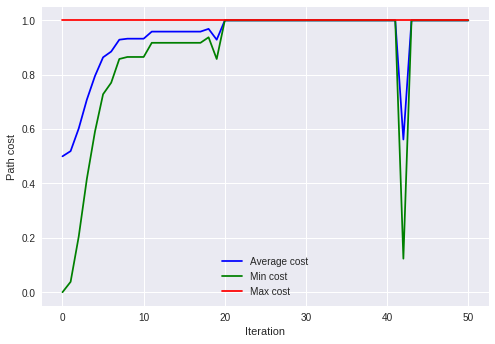

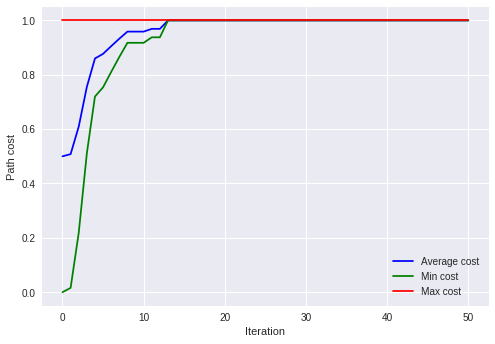

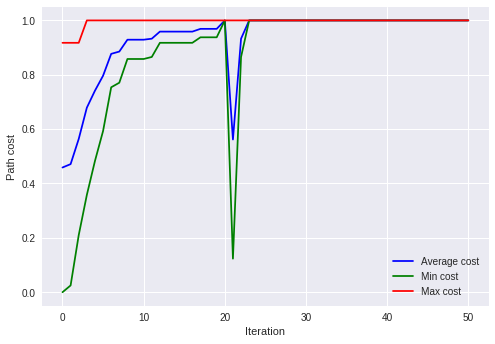

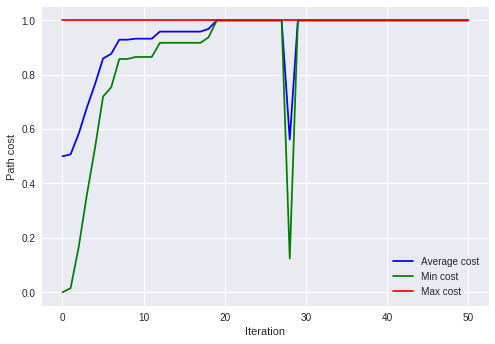

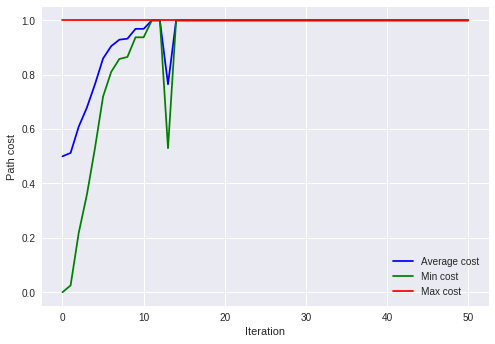

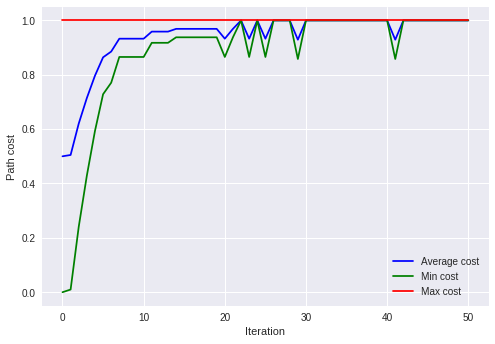

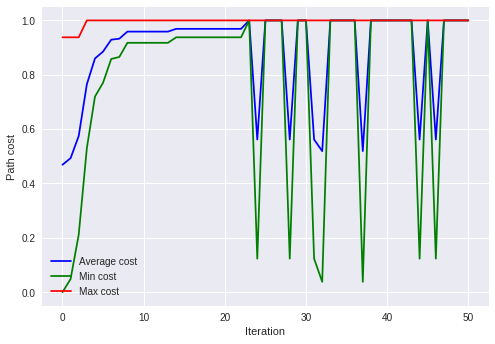

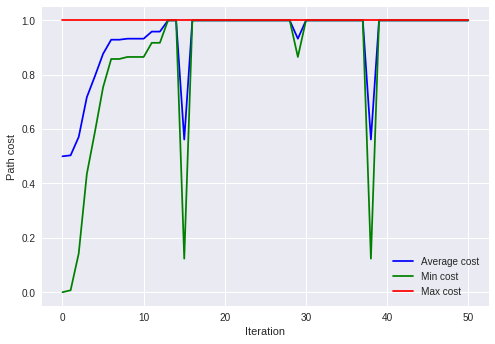

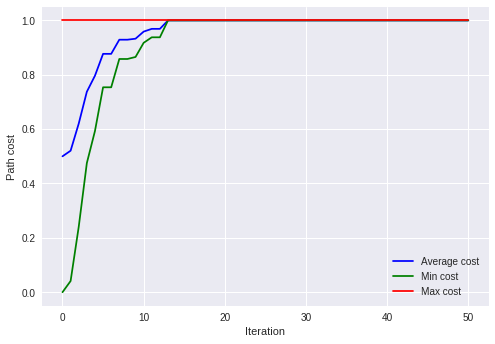

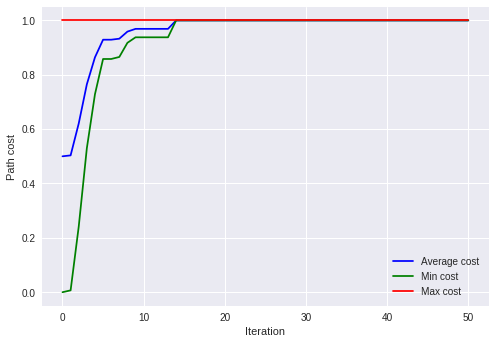

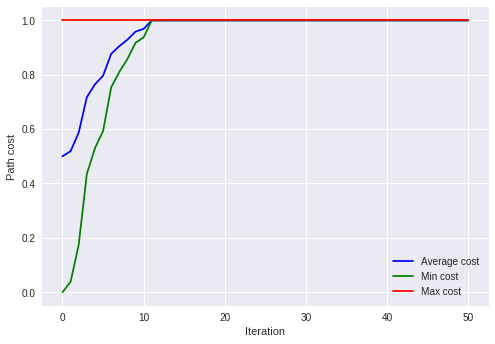

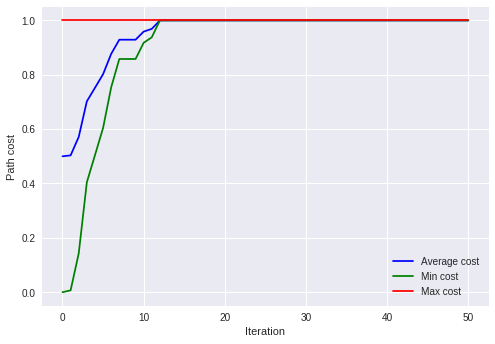

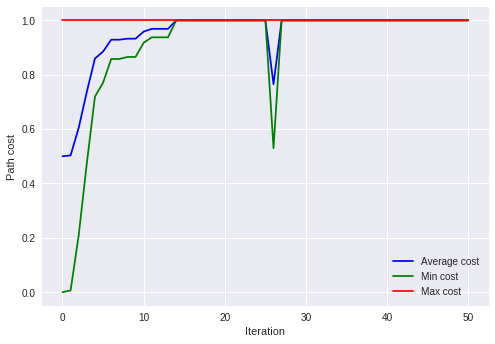

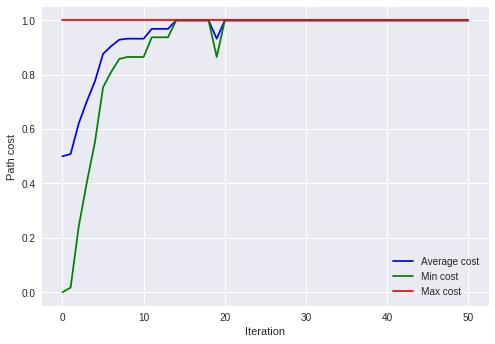

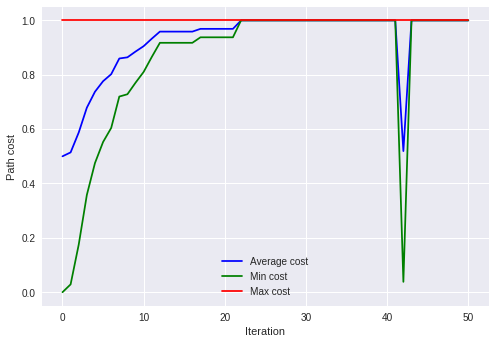

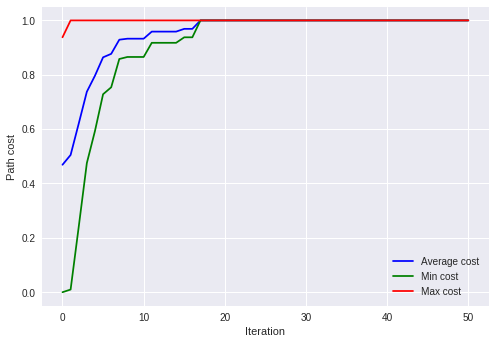

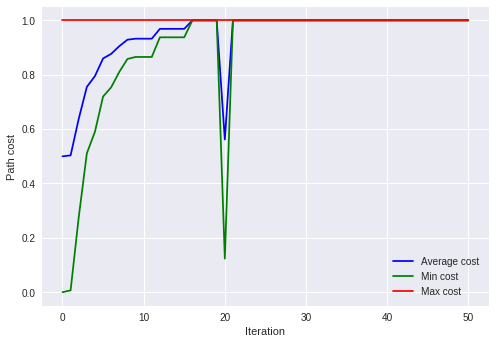

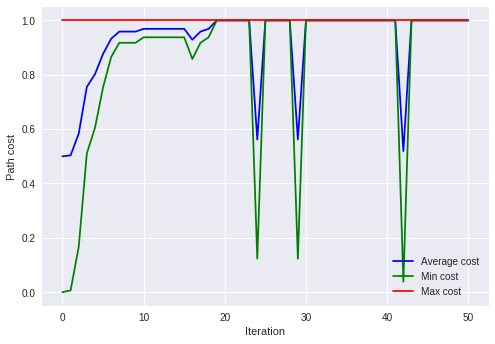

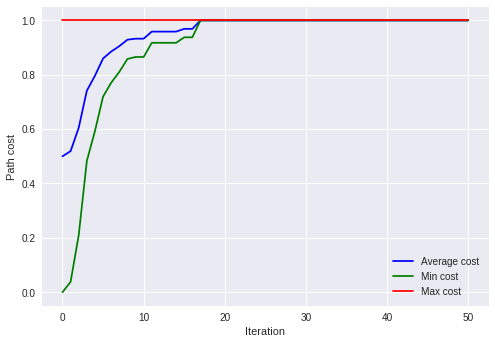

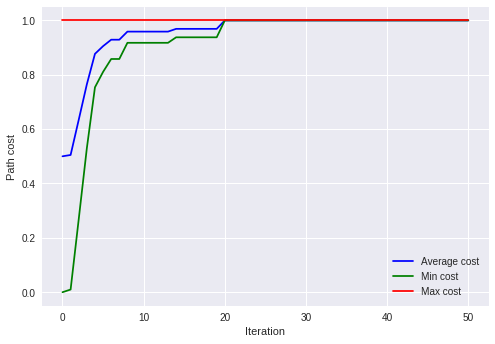

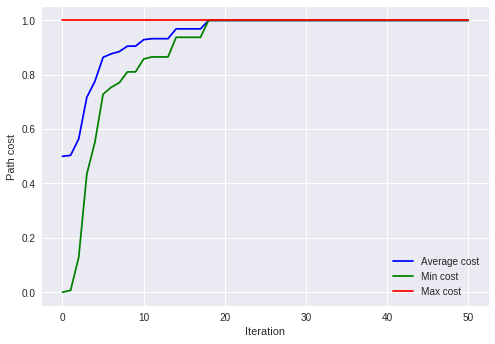

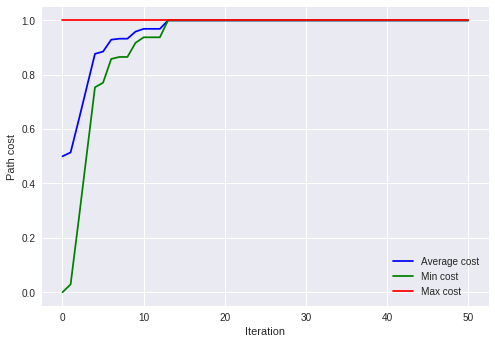

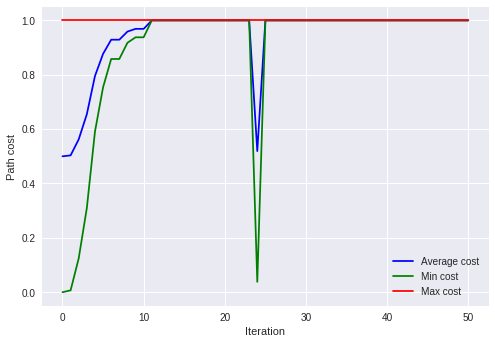

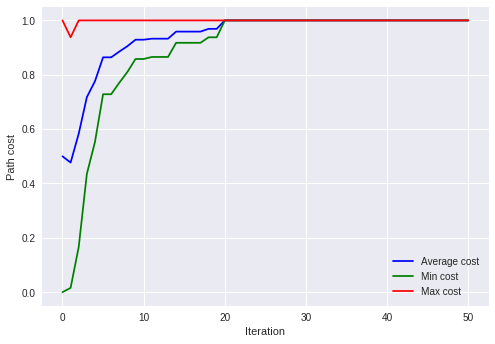

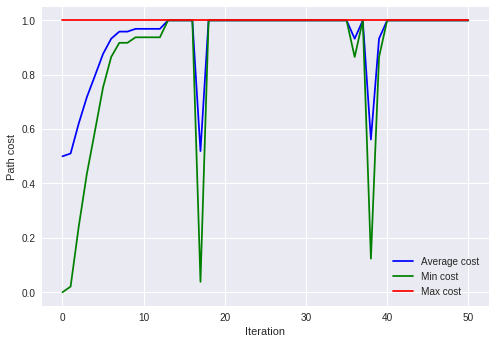

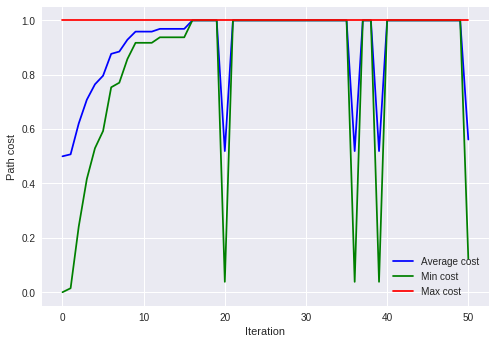

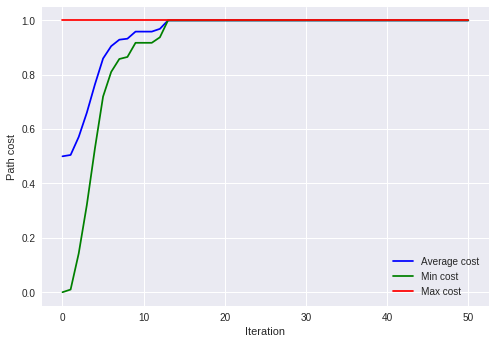

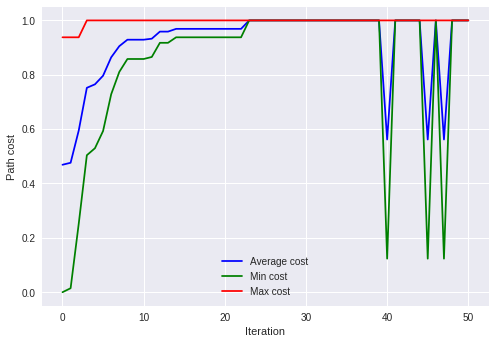

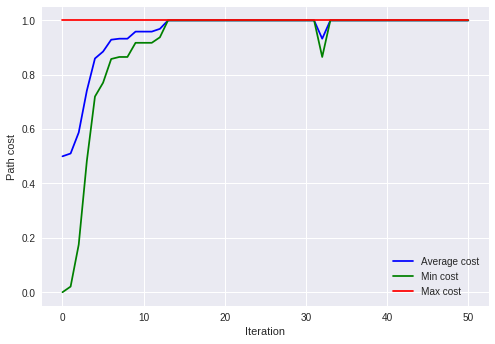

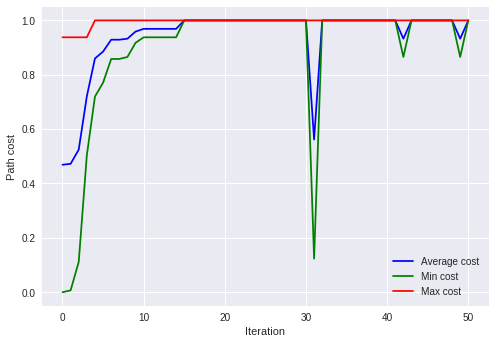

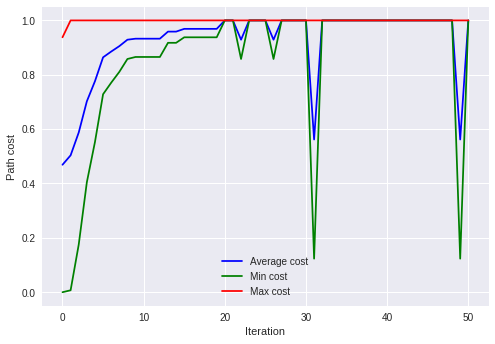

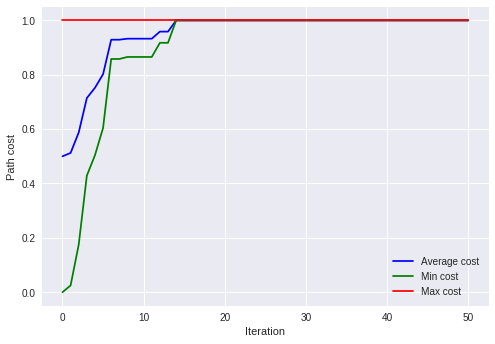

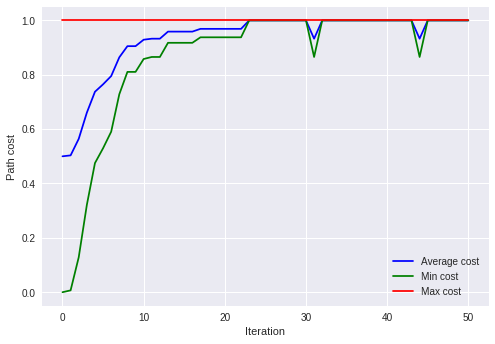

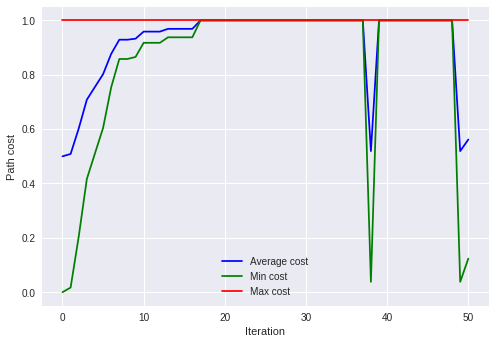

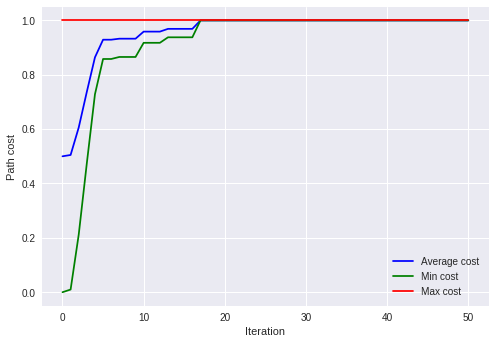

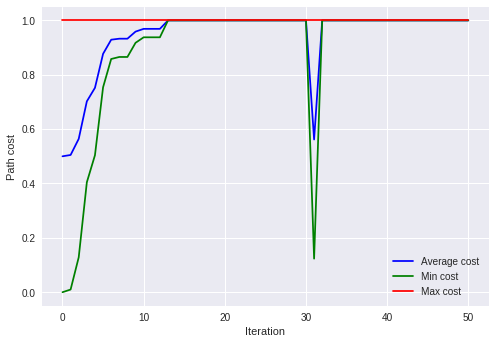

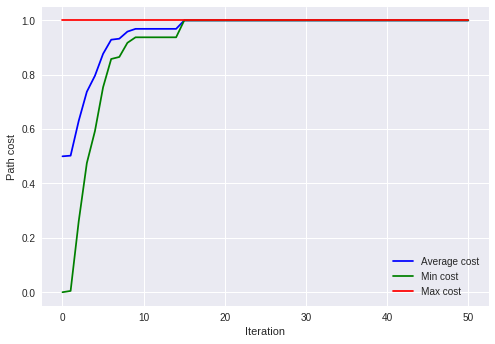

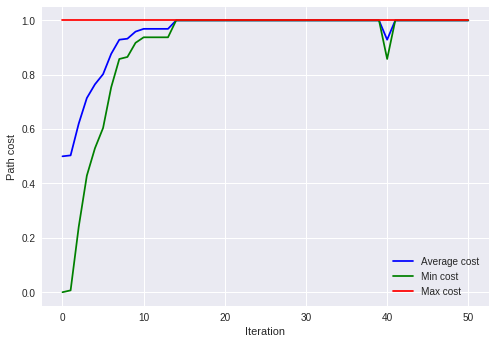

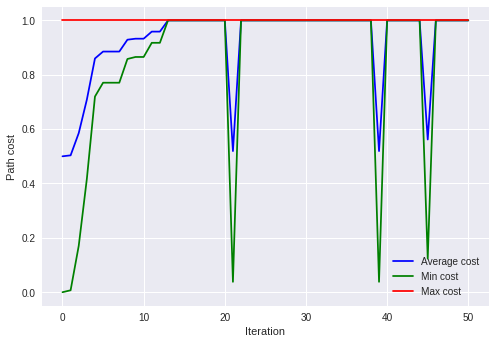

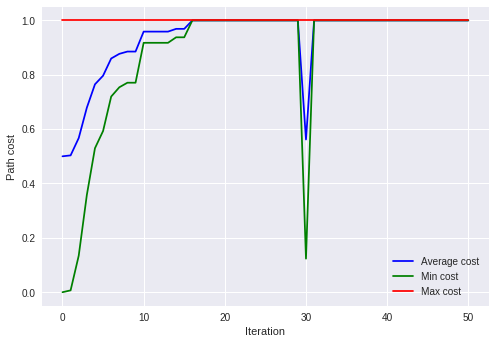

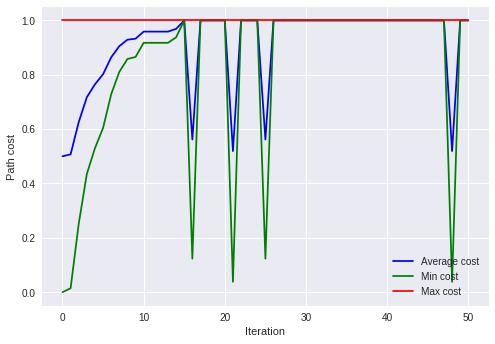

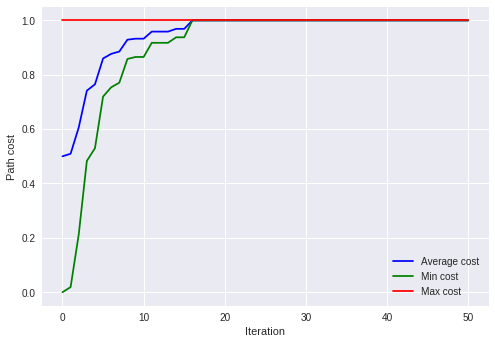

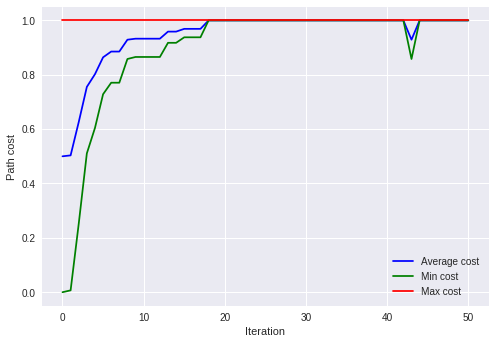

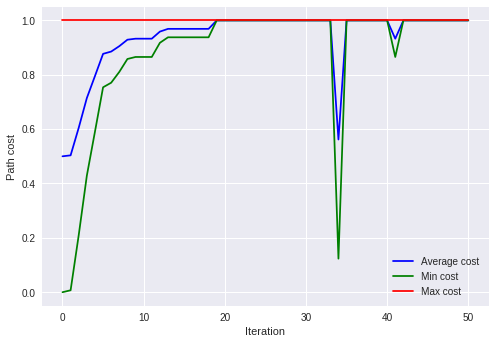

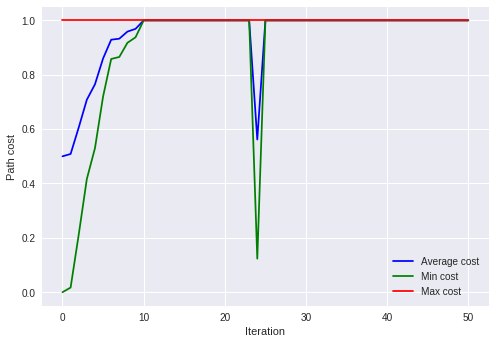

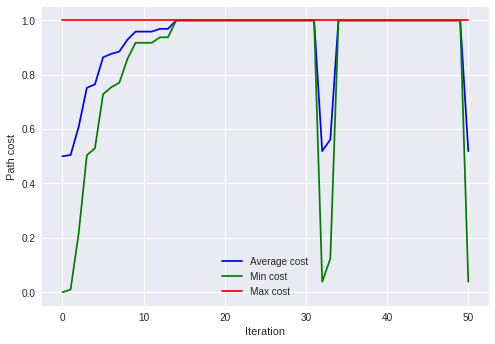

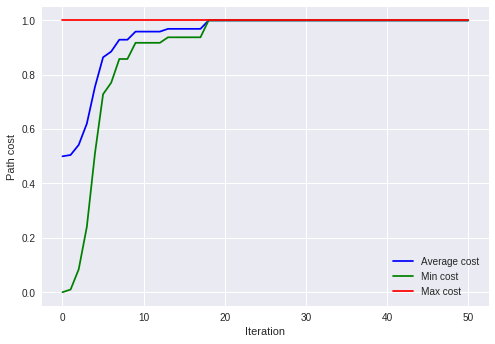

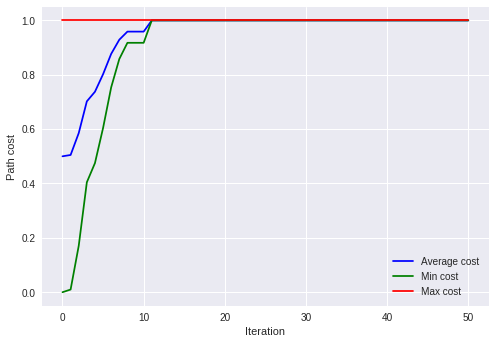

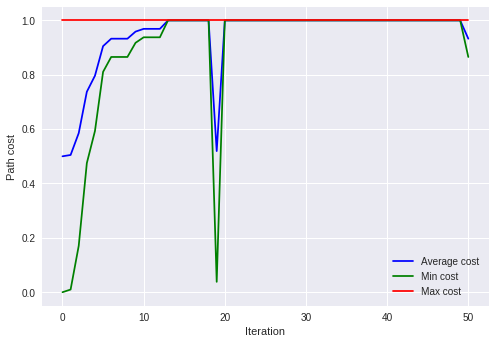

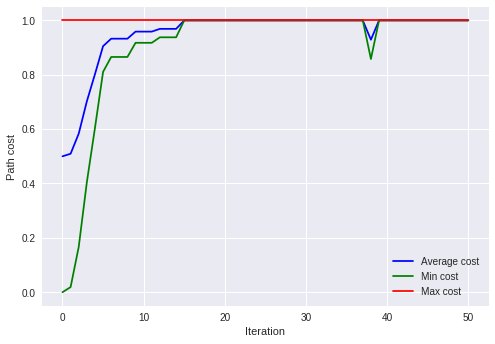

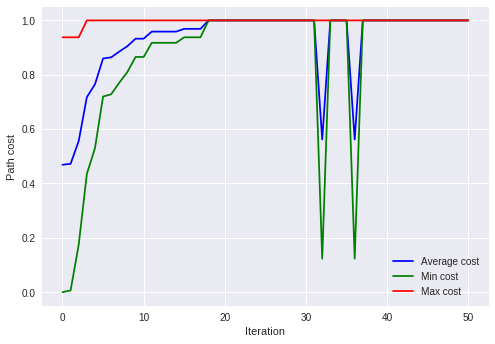

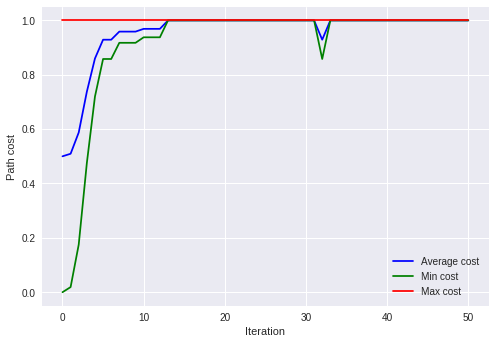

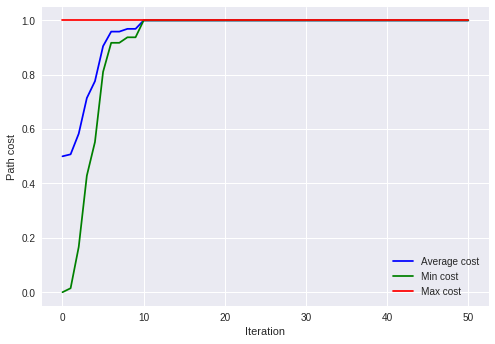

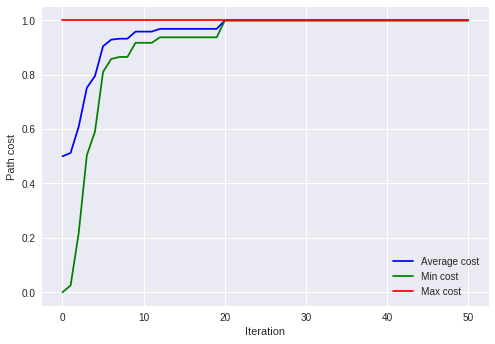

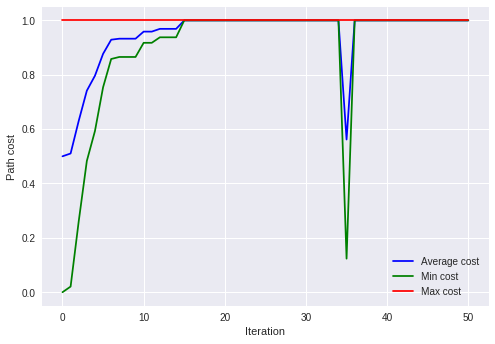

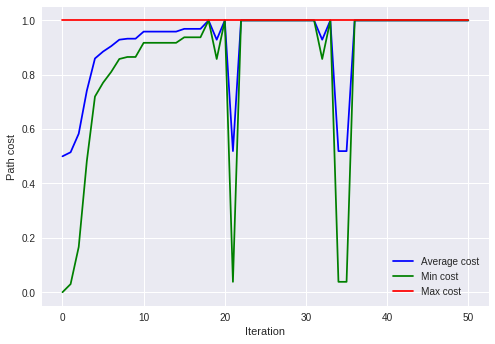

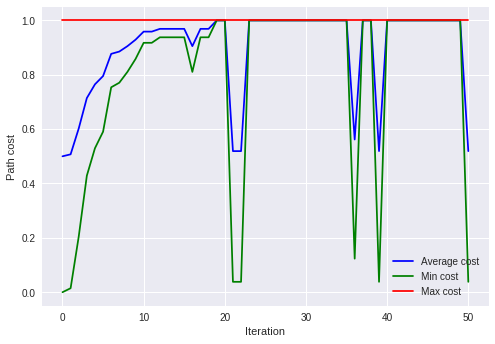

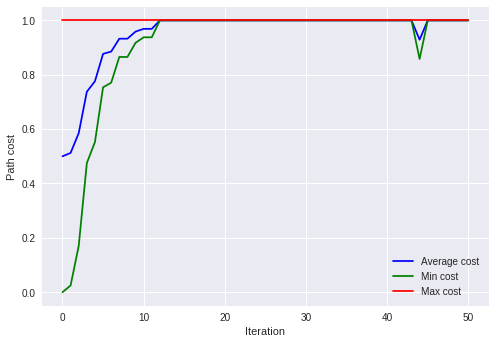

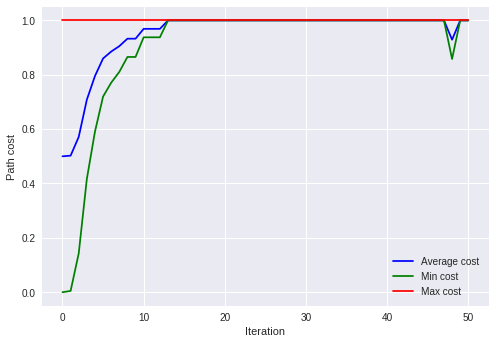

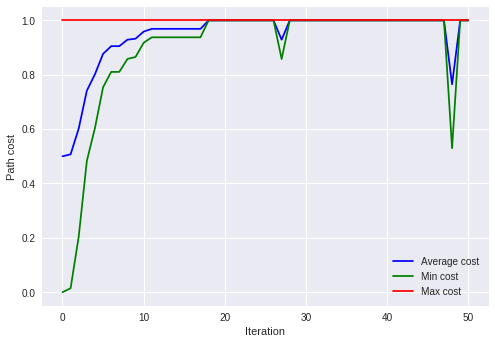

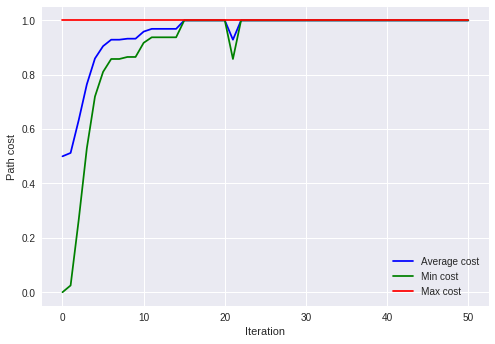

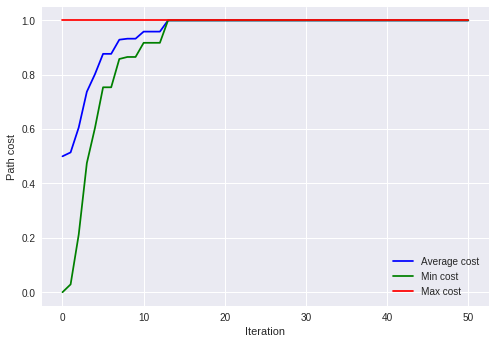

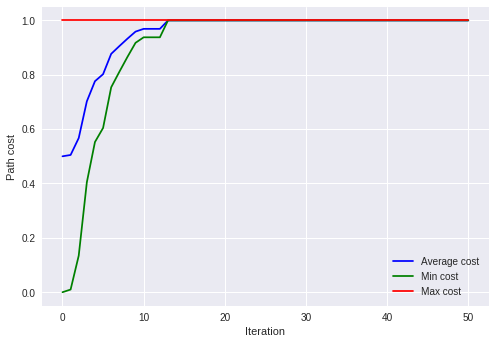

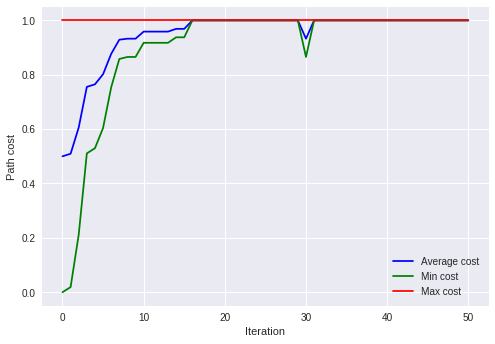

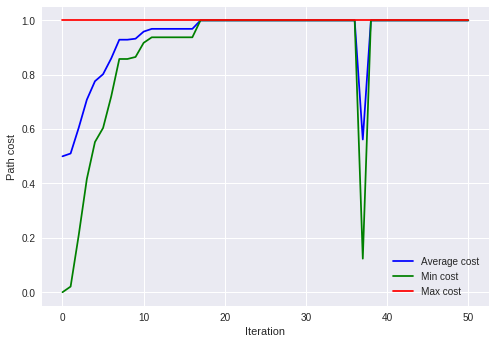

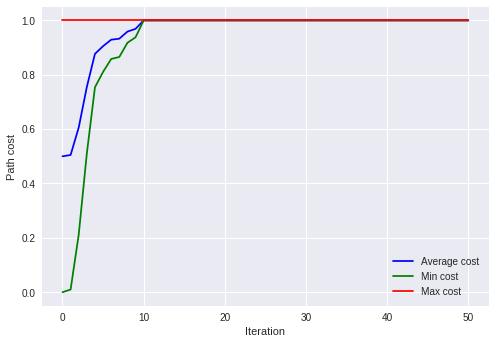

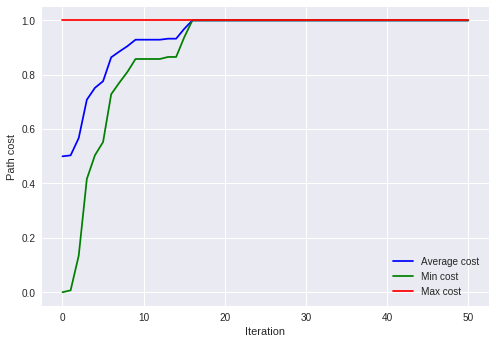

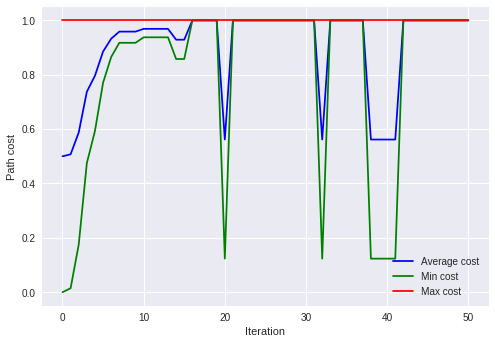

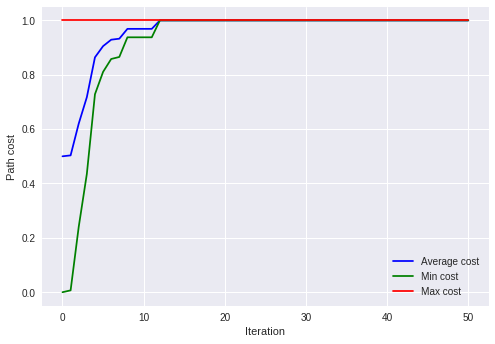

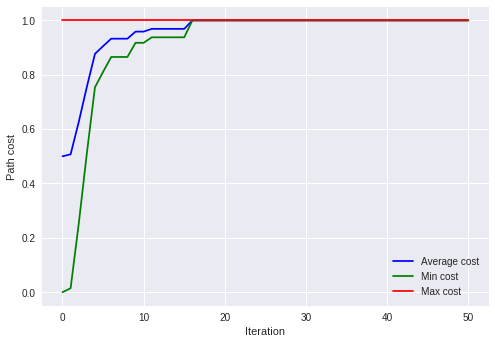

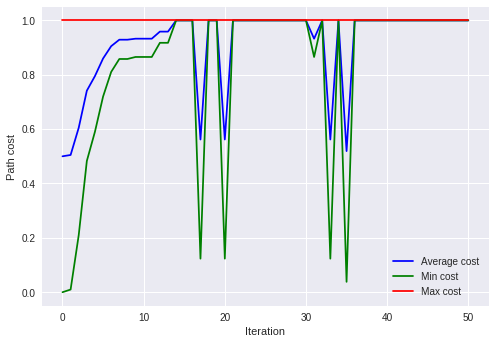

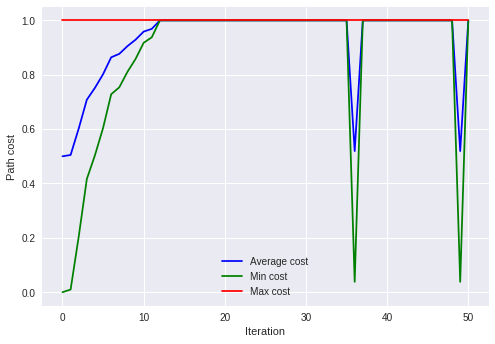

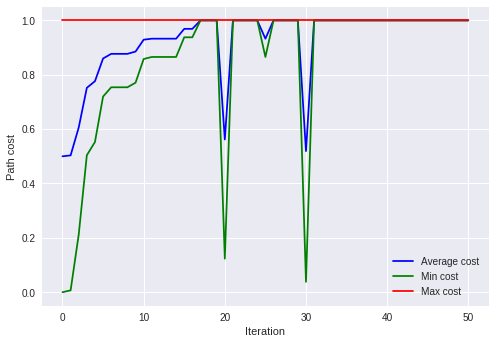

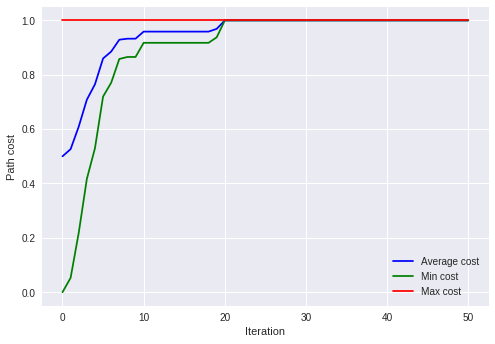

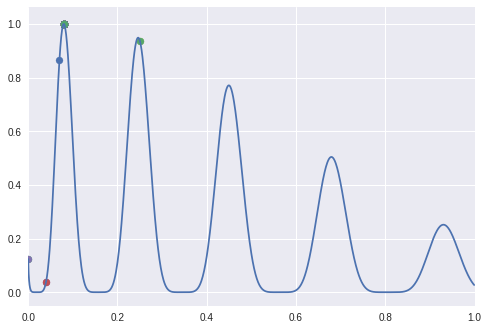

In [ ]:
population_size = 200
number_iterations = 50
number_solutions = 200
percentage_crossover = 0.95
crossover_method = 'Random cutpoint'
percentage_mutation = 0.1
function = 'M2'
jump = 0.001

best_solutions = GA_with_parallel_hillclimbing(population_size, number_iterations, number_solutions, percentage_crossover, crossover_method, percentage_mutation, function)
plot_solutions(best_solutions, function)

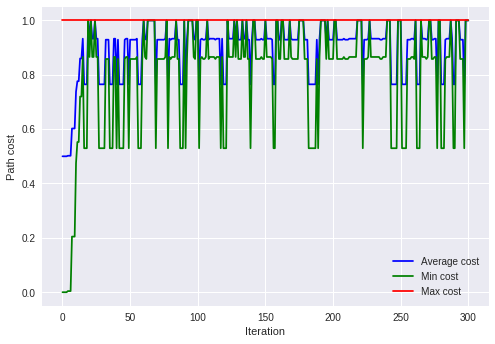

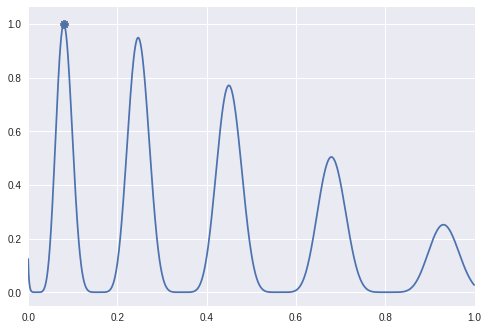

In [ ]:
population_size = 200
number_iterations = 300
crossover_method = 'Random section in middle'
function = 'M2'
jump = 0.001

best_solutions = GA_with_crowding(population_size, number_iterations, crossover_method, function)
plot_solutions(best_solutions, function)